# W207 Summer 2021 Final Project - Forest Cover Type Prediction ([Kaggle](https://www.kaggle.com/c/forest-cover-type-prediction))
##### By: Brenna Giacchino, Daniel Ryu, Gerrit Lensink, Ruby Han

## Abstract

Scientists study forest cover type classifications for a number of reasons -- whether they're monitoring changes in vegetation, studying how a change in climate affects vegetation, or looking at how to maintain a plot of land. Field studies and land-based remote sensing are traditional methods used for classifying forest cover types that are time-consuming, error-prone, and expensive<sup>1</sup>. Creating a model that classifies forest cover types may improve the reliability of the classification and efficiency of studying these geographical areas.

The goal of this project is to build a model that uses cartographic features about a cell of forest land to accurately predict the predominant kind of tree cover for the cell. We plan to tune and compare a variety of models, optimizing toward the highest possible $F_1$ score (a metric which balances precision and recall). All models will be trained on labeled data and tested against "development" data using an 80-20 split. 

The outcome variable (forest cover type) comes from the U.S. Forest Service, while the feature variables come from a combination of the U.S. Geological survey as well as the USFS. This data encapsulates four wilderness areas in the Roosevelt National Forest; because these areas are preserved from most human disturbance, we assume forest cover types are a result of natural processes represented by the independent variables (although this assumption is not necessary to generate an effective model).

<font size=1em> <i><sup>1</sup>Hugo Sjöqvist, Martin Längkvist & Farrukh Javed (2020) An Analysis of Fast Learning Methods for Classifying Forest Cover Types, Applied Artificial Intelligence, 34:10, 691-709, DOI: 10.1080/08839514.2020.1771523</i></font>


## Brief Overview of Results

We trained and tested a variety of models, beginning with Naive Bayes and ending with a multi-layer model that utilized KNN for the first layer and Random Forest for the two subsequent layers. We've listed the sequence of classifiers in the order we attempted them below:

1. Naive Bayes
2. KNN
3. Multi-layer KNN
4. Multi-layer multiple models (KNN, Random Forest)

This final model (4) yields an internal development accuracy of **85.6%** and F1 score of **85.3%**. The accuracies of previous models are also listed in the image below.

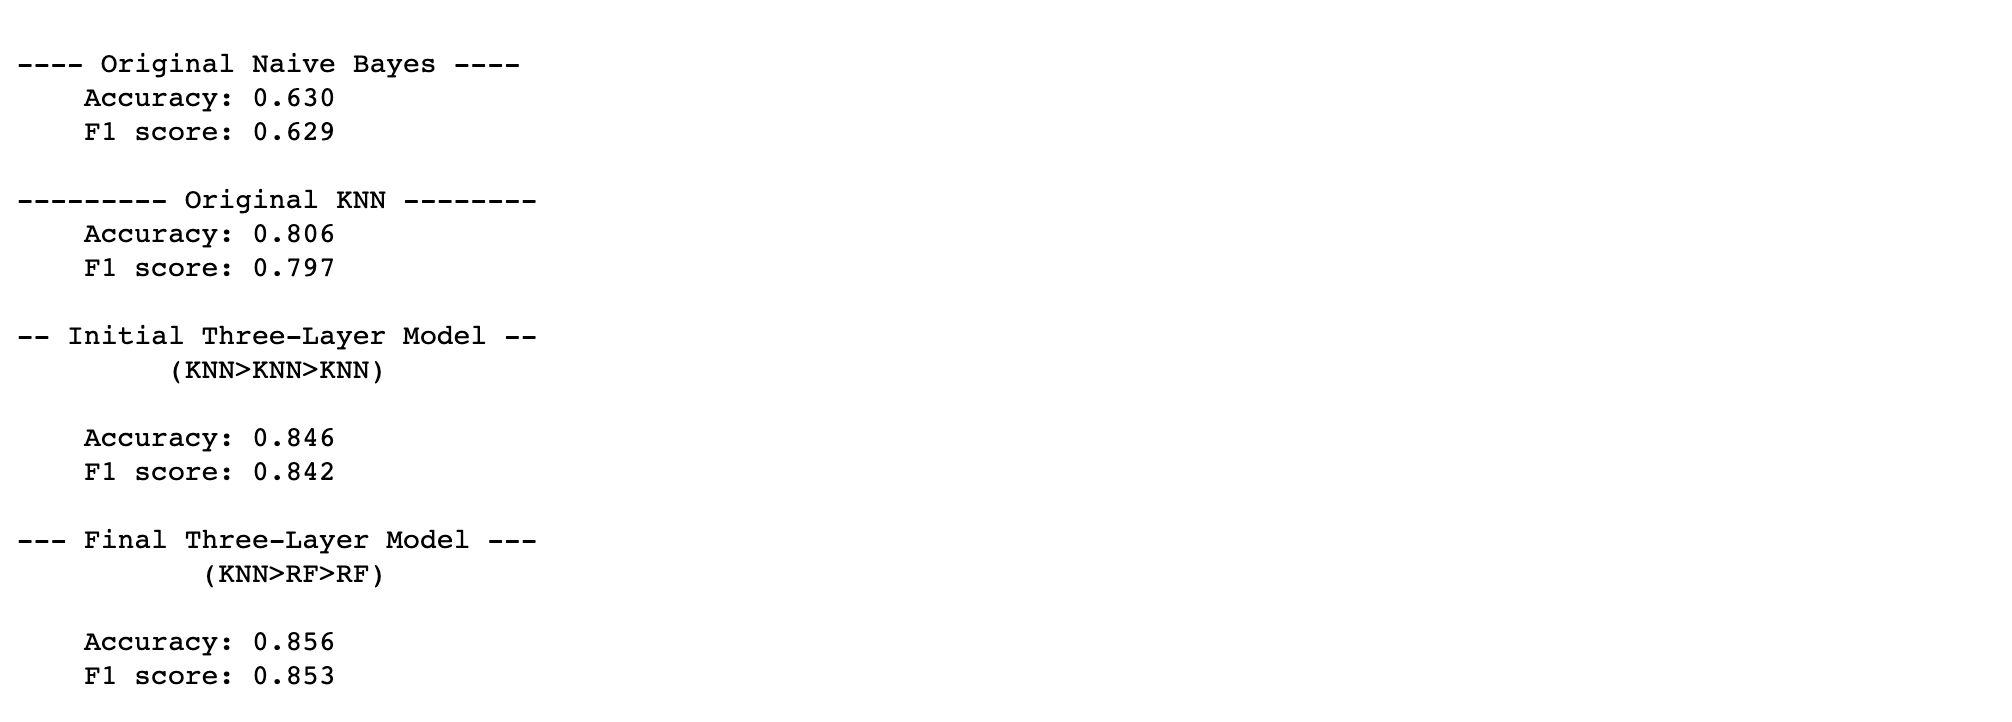

In [1]:
from IPython.display import Image, display
Image("../references/Summary.png")

## Inference Problem
**Inference Problem**: Given a set of cartographic features (X), predict the dominant tree cover (y) for the cell

**$X$**: Cartographic features of forest land, such as elevation, slope, distance to water, shade, and soil type

**$\hat{y}$**: Predominant class of tree cover for the given cell

Model: We trained a variety of models, including 
- K-Nearest Neighbors
- Naive Bayes
- Random Forests
- Multi-layer model

**Parameters**: 
- KNN: No Parameters stored
- Random Forest: Features to be split on, and split points

**Cost Functions**: 
- KNN: similarity with neighbors with measures like Euclidean Distance
- Random Forests: entropy gain at each split

**Objective**: Each of the models will have their own objective
- KNN: Minimize distance between different points in a cluster
- Random Forest: maximize entropy at each split


## Feature Definitions
The raw data contains a mixture of continuous and binary variables, as defined below: 

- `Elevation` - Elevation in meters
- `Aspect` - Aspect in degrees azimuth
- `Slope` - Slope in degrees
- `Horizontal_Distance_To_Hydrology` - Horz Dist to nearest surface water features
- `Vertical_Distance_To_Hydrology` - Vert Dist to nearest surface water features
- `Horizontal_Distance_To_Roadways` - Horz Dist to nearest roadway
- `Hillshade_9am` (0 to 255 index) - Hillshade index at 9am, summer solstice
- `Hillshade_Noon` (0 to 255 index) - Hillshade index at noon, summer solstice
- `Hillshade_3pm` (0 to 255 index) - Hillshade index at 3pm, summer solstice
- `Horizontal_Distance_To_Fire_Points` - Horz Dist to nearest wildfire ignition points
- `Wilderness_Area` (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- `Soil_Type` (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- `Cover_Type` (7 types, integers 1 to 7) - Forest Cover Type designation

Additional transformed variables to potentially train our models:
- `Total_Distance_To_Hydrology` - Euclidean distance using "Horizontal" and "Vertical" distances
- Binned versions of continuous variables (binary and multinomial)

## <a id = 0> </a>Navigation
- [1. Data Load](#1)
- [2. Exploratory Data Analyses](#2)
    - [Histograms](#3)
    - [Scatter Plots](#4)
    - [Correlation Matrix](#5)
    - [Violin Plots](#6)
    - [Wilderness Area and Soil Types](#7)
- [3. Data Transformation](#8)
- [4. Initial Model Building/Selection](#9)
    - [Naive Bayes](#10) 
    - [Basic KNN](#11)
- [5. Multi-Layer Modeling](#12)
    - [Basic Three-Layer Model (KNN > KNN > KNN)](#13)
    - [Final Three-Layer Model (KNN > RF > RF)](#14)
- [6. Result Summary](#15)
    - [Future Improvements](#16)
- [7. Appendix](#17)
    - [Appendix A](#18)
    - [Appendix B](#19)
    - [Appendix C](#20)

In [2]:
# General libraries
import numpy as np
import pandas as pd
import re
import time

# SK-learn - learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# SK-learn - feature processing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# SK-learn - evaluation libraries
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Producing Decision Tree diagrams
from IPython.display import Image, display
import pydotplus
from subprocess import call

# Other
from itertools import compress
from textwrap import wrap

# Expand rows/columns in df outputs
pd.set_option(
    'max_columns', None,
    'max_colwidth', None
)

import warnings
warnings.filterwarnings(action='ignore')

## <a id = 1> </a> 1. Data Load
[Back to Navigation](#0)

- After shuffling the original dataset, we conducted an 80/20 split between the training and the development data.
- Refer to following directory for data split specifics:
    
    `w207_finalproject_group2/src/data/data_load.ipynb` 

In [3]:
train_data = pd.read_csv('../data/processed/train_data.csv').set_index('Id')
train_labels = pd.read_csv('../data/processed/train_labels.csv').set_index('Id')
dev_data = pd.read_csv('../data/processed/dev_data.csv').set_index('Id')
dev_labels = pd.read_csv('../data/processed/dev_labels.csv').set_index('Id')

In [4]:
print(
    f'Train Data Shape:   {train_data.shape}'
    f'\nTrain Labels Shape: {train_labels.shape}'
    f'\nDev Data Shape:     {dev_data.shape}'
    f'\nDev Labels Shape:   {dev_labels.shape}'
     )

Train Data Shape:   (12096, 54)
Train Labels Shape: (12096, 1)
Dev Data Shape:     (3024, 54)
Dev Labels Shape:   (3024, 1)


#### Train and Dev Datasets with Labels for EDA Purposes

In [5]:
train = train_data.merge(train_labels, how = 'left', on = train_data.index)\
        .set_index(train_data.index)\
        .drop(['key_0'], axis = 1)

dev = dev_data.merge(dev_labels, how = 'left', on = dev_data.index)\
        .set_index(dev_data.index)\
        .drop(['key_0'], axis = 1)

## <a id = 2> </a>2. Exploratory Data Analysis
[Back to Navigation](#0)

Our EDA section includes data cleaning and charts for discerning between characteristics belonging to each cover type. More specifically, we'd like to investigate if any cover types would be difficult to disambiguate based on similar feature distributions. 

We begin with simple exploration, investigating the features and their data types, then move on to plotting histograms, scatterplots, a correlation matrix, and violin plots to become more familiar with the intricacies of our dataset.

In [6]:
# Column List
train_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [7]:
# Statistics Summary
train_data.describe()

Elevation        Aspect         Slope  \
count  12096.000000  12096.000000  12096.000000   
mean    2749.726521    156.831845     16.520089   
std      417.449621    110.154121      8.446985   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3103.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      12096.000000                    12096.000000   
mean                         227.386574                       51.023231   
std                          209.953696                       61.388316   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       80.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     12096.000000   12096.000000    12096.000000   
mean                       1717.758681     212.498760      218.965278   
std                        1322.600326      30.769027       22.804008   
min                           0.000000       0.000000       99.000000   
25%                         767.000000     196.000000      207.000000   
50%                        1318.000000     220.000000      223.000000   
75%                        2274.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  Wilderness_Area1  \
count   12096.000000                        12096.000000      12096.000000   
mean      135.338542                         1509.334077          0.236690   
std        45.883196                         1093.325968          0.425068   
min         0.000000                            0.000000          0.000000   
25%       107.000000                          731.000000          0.000000   
50%       138.000000                         1253.000000          0.000000   
75%       168.000000                         1987.250000          0.000000   
max       248.000000                         6853.000000          1.000000   

       Wilderness_Area2  Wilderness_Area3  Wilderness_Area4    Soil_Type1  \
count      12096.000000      12096.000000      12096.000000  12096.000000   
mean           0.031581          0.423528          0.308201      0.024802   
std            0.174888          0.494138          0.461769      0.155526   
min            0.000000          0.000000          0.000000      0.000000   
25%            0.000000          0.000000          0.000000      0.000000   
50%            0.000000          0.000000          0.000000      0.000000   
75%            0.000000          1.000000          1.000000      0.000000   
max            1.000000          1.000000          1.000000      1.000000   

         Soil_Type2    Soil_Type3    Soil_Type4    Soil_Type5    Soil_Type6  \
count  12096.000000  12096.000000  12096.000000  12096.000000  12096.000000   
mean       0.041584      0.062417      0.054894      0.010830      0.042989   
std        0.199645      0.241922      0.227783      0.103507      0.202842   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       Soil_Type7  Soil_Type8    Soil_Type9   Soil_Type10   Soil_Type11  \
count     12096.0     12096.0  1

In [8]:
# Check data types for each field
# (Truncated for visual purposes)
train_data.dtypes.head()

Elevation                           int64
Aspect                              int64
Slope                               int64
Horizontal_Distance_To_Hydrology    int64
Vertical_Distance_To_Hydrology      int64
dtype: object

In [9]:
# Check null values
# (Truncated for visual purposes)
train_data.isna().sum().head()

Elevation                           0
Aspect                              0
Slope                               0
Horizontal_Distance_To_Hydrology    0
Vertical_Distance_To_Hydrology      0
dtype: int64

In [10]:
train_data.isna().sum().sum()

0

**Observations**
- All data fields are int64 objects
- `Wilderness_Area` and `Soil_Type` are binary features
- `Cover_Type` is categorized from 1-7
- The rest of the fields are continuous
- No null values

### <a id = 3> </a>Histograms
[Back to Navigation](#0)

- Because we randomly split our train and dev data, we expect the feature distributions of the train data to compare similarly to the feature distributions of our dev data. This will be key for generalization across the dev data, as well as the final test data. The histograms below show the distributions of the continuous features of the training data.

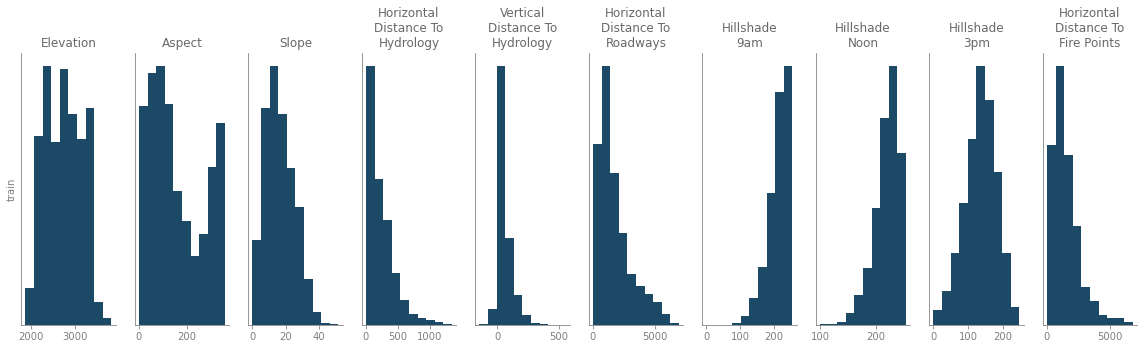

In [11]:
# Strip underscores from feature names for nice printing
formatted_cols = (train_data.columns).str.replace('_', ' ')

# Plot Formatting
plt.rcParams.update({'text.color' : "dimgrey",
                     'axes.labelcolor' : "grey"})

datasets = [train_data]
data_names = ['train']

fig, axes = plt.subplots(1, 10)

# Loop through to show hist of non-binary for each 
for d, data in enumerate(datasets):    # For each dataset (only needed when comparing dev and train)
    for i in np.arange(0, 10):          # For each non-binary figure in dataset
        data.iloc[:, i].plot.hist(ax = axes[i], 
                                    figsize = (20,5), 
                                    sharex = True, color = '#1c4966')
        # Column and Row names for each plot
        if (i == 0) and (d == 0):    # Top Left Corner
            axes[i].set_ylabel(data_names[d])
            axes[i].set_title("\n".join(wrap(formatted_cols[i], 12)))
        
        elif i == 0:    # First Column
            axes[i].set_ylabel(data_names[d])
    
        elif d == 0:    # First Row
            axes[i].set_ylabel('')
            axes[i].set_title("\n".join(wrap(formatted_cols[i], 12)))
        else:
            axes[i].set_ylabel('')
            
        # For All Plots
        axes[i].set_yticks([])
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_color('grey')
        axes[i].spines['bottom'].set_color('grey')
        axes[i].tick_params(colors = 'grey')

plt.show()

**Observations:**
- Most of the histograms are not normally distributed (although this isn't a requirement for our model implementation), but instead skewed to one side.
- The most unique histogram is `Aspect`, which has a bimodal distribution.
- Looking at histograms of data grouped by cover type may allow us distinguish key features in the data set (see the "Scatterplots" section)

### <a id = 4> </a> Scatterplots 
[Back to Navigation](#0)

- Scatterplots may reveal correlational or non-linear relationships between features. In the figure below, the color of each datapoint represents a forest cover type, which will help reveal if the relationship between two features varies by class.
- Additionally, the distributions shown along the diagonal of the figure will indicate how the spreads differ by cover type.

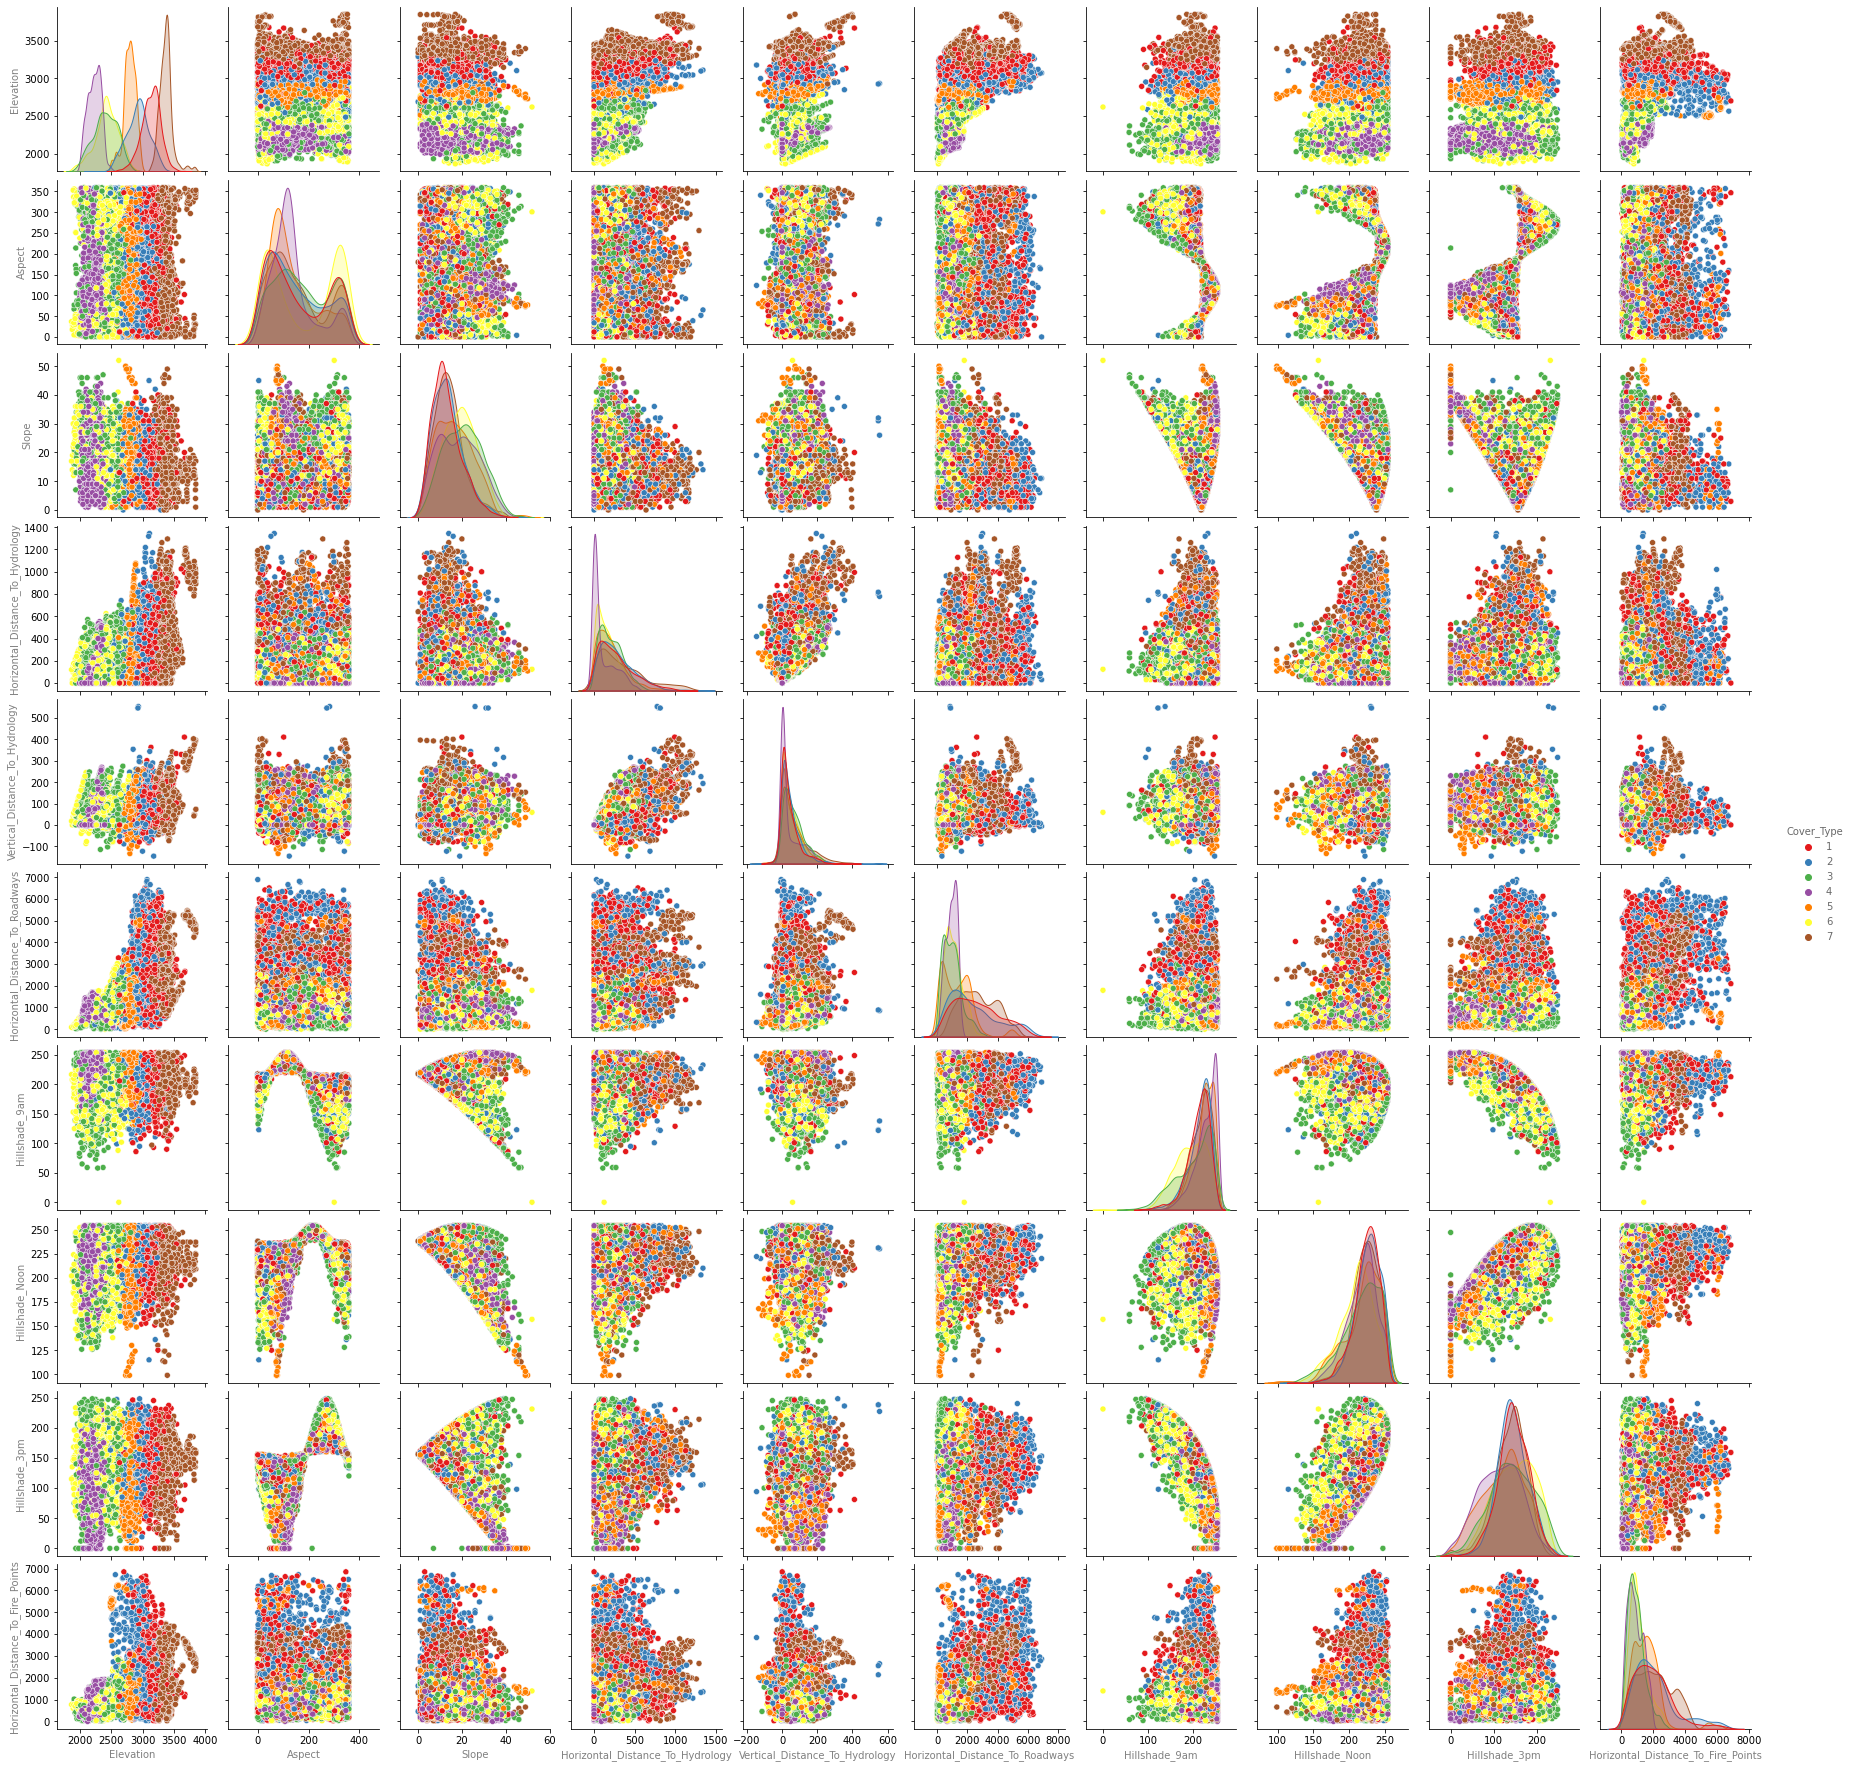

In [12]:
train_data_copy = train.copy().iloc[:, :10]
train_data_copy["Cover_Type"] = train.Cover_Type

# The different colors indicate Cover_Type
sns.pairplot(train_data_copy, kind="scatter", hue="Cover_Type", palette="Set1")
plt.show()

**Observations**
- `Elevation` appears to have the the most variation between cover type distributions.
- Cover Types 1 and 2 (red and blue) tend to be grouped together frequently in each of the scatterplots.
- Cover Types 3 and 6 (green and yellow) tend to be grouped together frequently in each of the scatterplots.
- `Horizontal_Distance_To_Hydrology`, and `Vertical_Distance_To_Hydrology` seem to have a positive linear relationship.
- The `Hillshade` variables seem to have nonlinear relationships with each other, since the bounds on these variables cause these scatterplots to have rounded edges. Note the peculiar shape of the scatterplots between the `Hillshade` variables with `Aspect` and `Slope` as well.
- The abundance of data points makes it difficult to determine if a linear relationship between features of individual cover types.

### <a id = 5> </a>Correlation Matrix
[Back to Navigation](#0)

- The correlation matrix provides a numerical representation of the strength of the linear relationship between each continuous feature. 

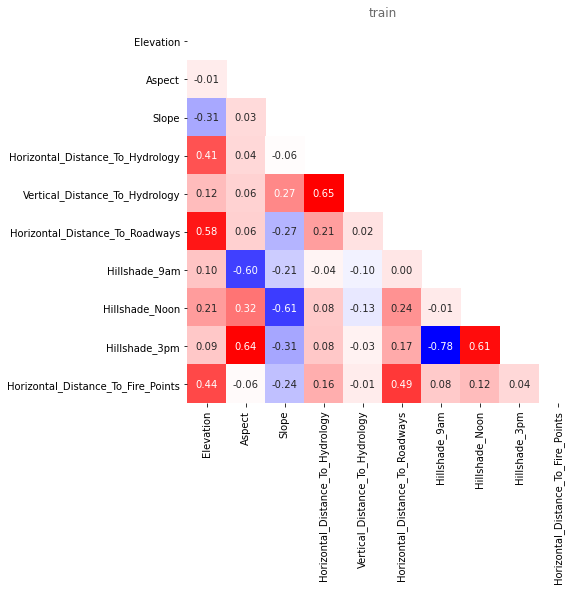

In [13]:
fig, axes = plt.subplots(1, 1, sharey = True, figsize = (7,7))

datasets = [train]    
data_names = ['train']

# Correlation plot for each dataset - numeric values
for i, data in enumerate(datasets):    # For each dataset

    corr = data.iloc[:, :10].corr()    # Set the correlation matrix
    
    # Mask to upper triangular
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    # Plot correlation heatmap
    sns.heatmap(corr, 
                xticklabels = corr.columns.values,
                yticklabels = corr.columns.values, 
                cmap = 'bwr', 
                annot = True, 
                mask = mask, 
                fmt = '.2f',
                ax = axes,
                cbar = False).set(title = data_names[i])

plt.show()

**Observations**
- `Horizontal_Distance_To_Hydrology` and `Vertical_Distance_To_Hydrology` have a correlation of 0.65, supporting our observation from the scatterplot that they have a positive linear relationship.
- `Hillshade_9am` and `Hillshade_3pm` have the most negative correlation (-0.78), and `Hillshade_Noon` and `Hillshade_3pm` have a high positive correlation (0.61).
- This chart supports our additional observations about the above scatterplots.

### <a id = 6> </a>Violin Plot for Continuous Features

[Back to Navigation](#0)

- Violin plots are used for visualizing distribution and probability density. While they are similar to box plots in that they are used for reviewing summary statistics, they also allow us to see variations in the data for distributions that aren't necessarily unimodal.

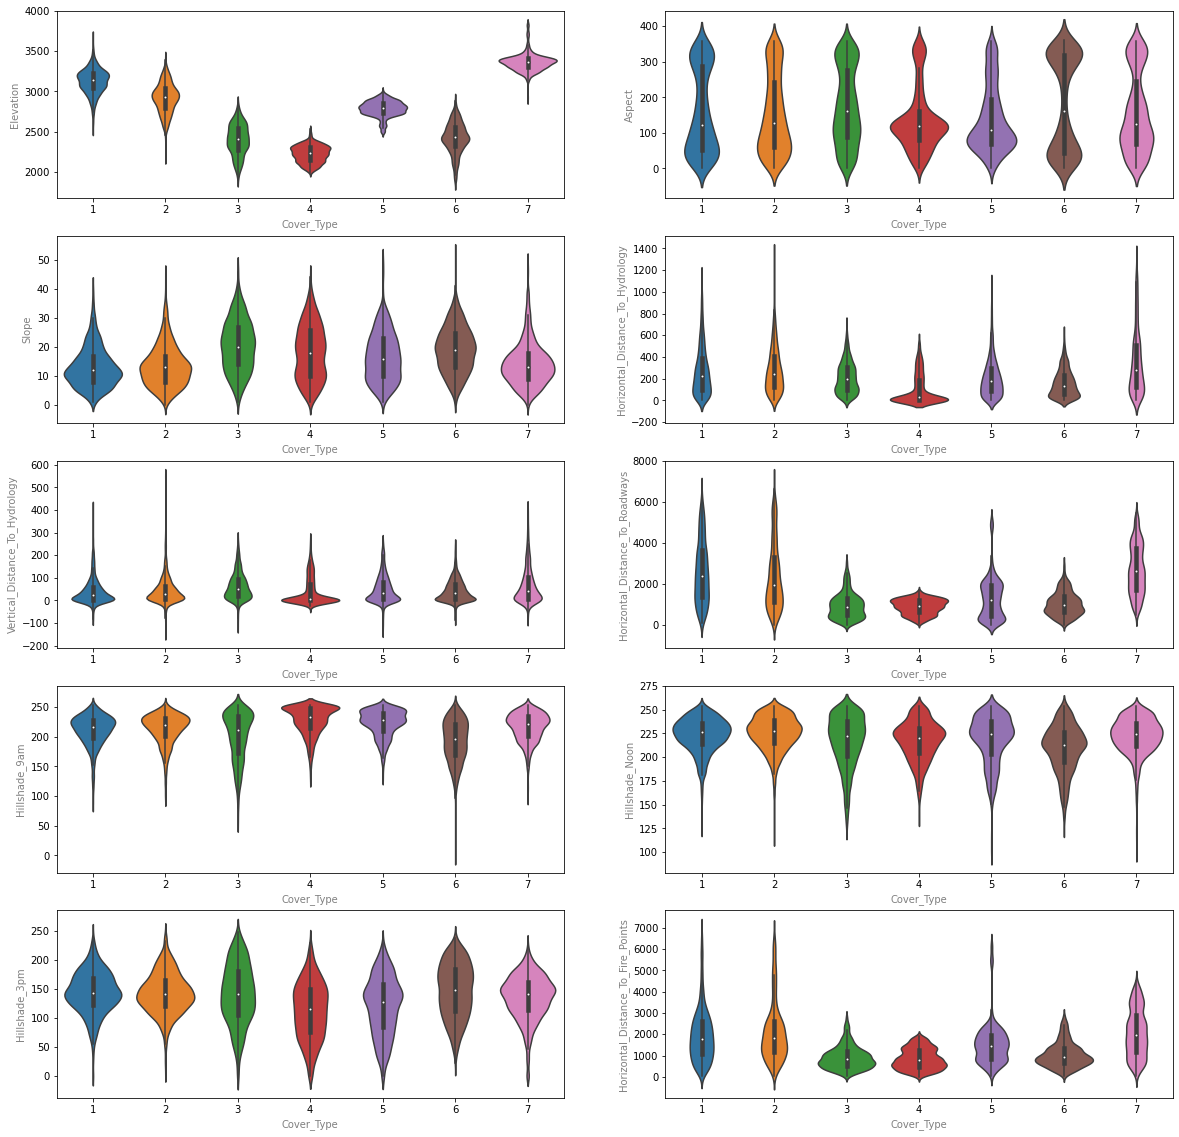

In [14]:
# Violin plot
fig, axes = plt.subplots(5, 2, figsize = (20, 20))
col_list = ['Elevation', 'Aspect', 'Slope',
            'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
            'Horizontal_Distance_To_Roadways','Hillshade_9am',
            'Hillshade_Noon', 'Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
i = 0
for col_name in col_list:
    row = i // 2
    col = i % 2
    sns.violinplot(x='Cover_Type', y=col_name, data=train , ax=axes[row][col])
    i = i + 1

**Observations**
- `Elevation` varies based on `Cover_Type`, indicating that this will be an important variable for prediction.
- Cover types 1 and 2 have very similar shapes for each of the features above, further conveying the potential of ambiguities between the two.
- Similarly, the plots for cover types 3 and 6 have similar shapes for each feature.
- Many of the plots are elongated, suggesting that many of the feature values contain outliers.

### <a id = 7> </a>`Wilderness_Area` and `Soil_Type` Binary Features Exploration
[Back to Navigation](#0)

- We also wanted to investigate how the cover types were distributed among the binary features. We created a bar chart of the `Wilderness Type` variables and clustered the cover type counts around each of the categories. Then we repeated the process for the `Soil Type` variables.
- We believed that we could utilize these charts for feature selection. For example, for two cover types that are commonly incorrectly predicted, we may want to remove soil types where these two cover types have similar distributions.

In [15]:
soil_list = []
for i in range(40):
    soil_list.append(f'Soil_Type{i+1}')

wild_area_list = ['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']

In [16]:
# Unpivot df from wide to long format by combining `Soil_Type#` and `Wilderness_Area#` to one column each
X_train_df_comb = pd.melt(train, 
                          id_vars=col_list+soil_list+['Cover_Type'], 
                          value_vars=wild_area_list, 
                          var_name='Wilderness_Area')
X_train_df_comb2 = X_train_df_comb[X_train_df_comb.value != 0].drop(columns=['value'])

X_train_df_comb3 = pd.melt(X_train_df_comb2, 
                          id_vars=col_list+['Wilderness_Area', 'Cover_Type'], 
                          value_vars=soil_list, 
                          var_name='Soil_Type')
X_train_df_comb4 = X_train_df_comb3[X_train_df_comb3.value != 0].drop(columns=['value'])

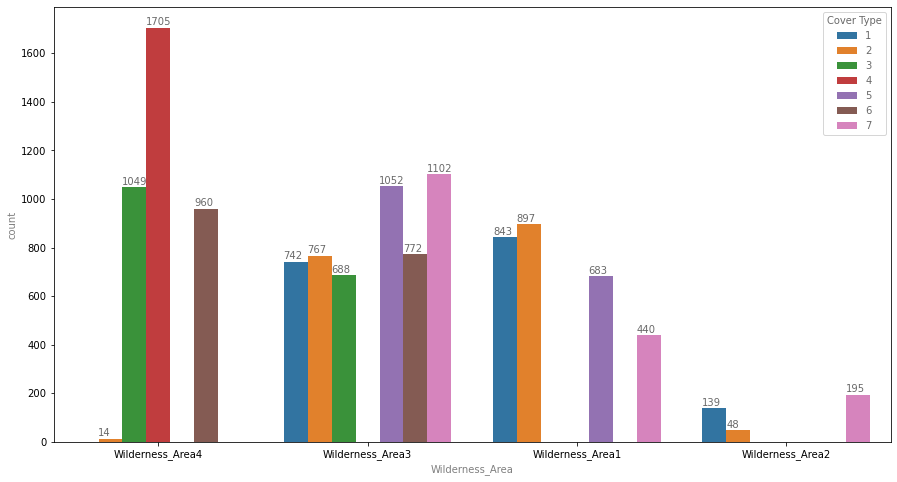

In [17]:
# Count plot - Combined Wilderness Area
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='Wilderness_Area', hue='Cover_Type', data=X_train_df_comb4)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x()-0.001, p.get_height()+10))
plt.legend(loc='upper right', title='Cover Type')
plt.show()

**Observations**
- Cover type 4 only exists in Wilderness Area 4.
- There is a fairly equal representation of wilderness area counts, except for Wilderness Area 2.
- Again, cover types 1 and 2 have about the same counts for each Wilderness Area.

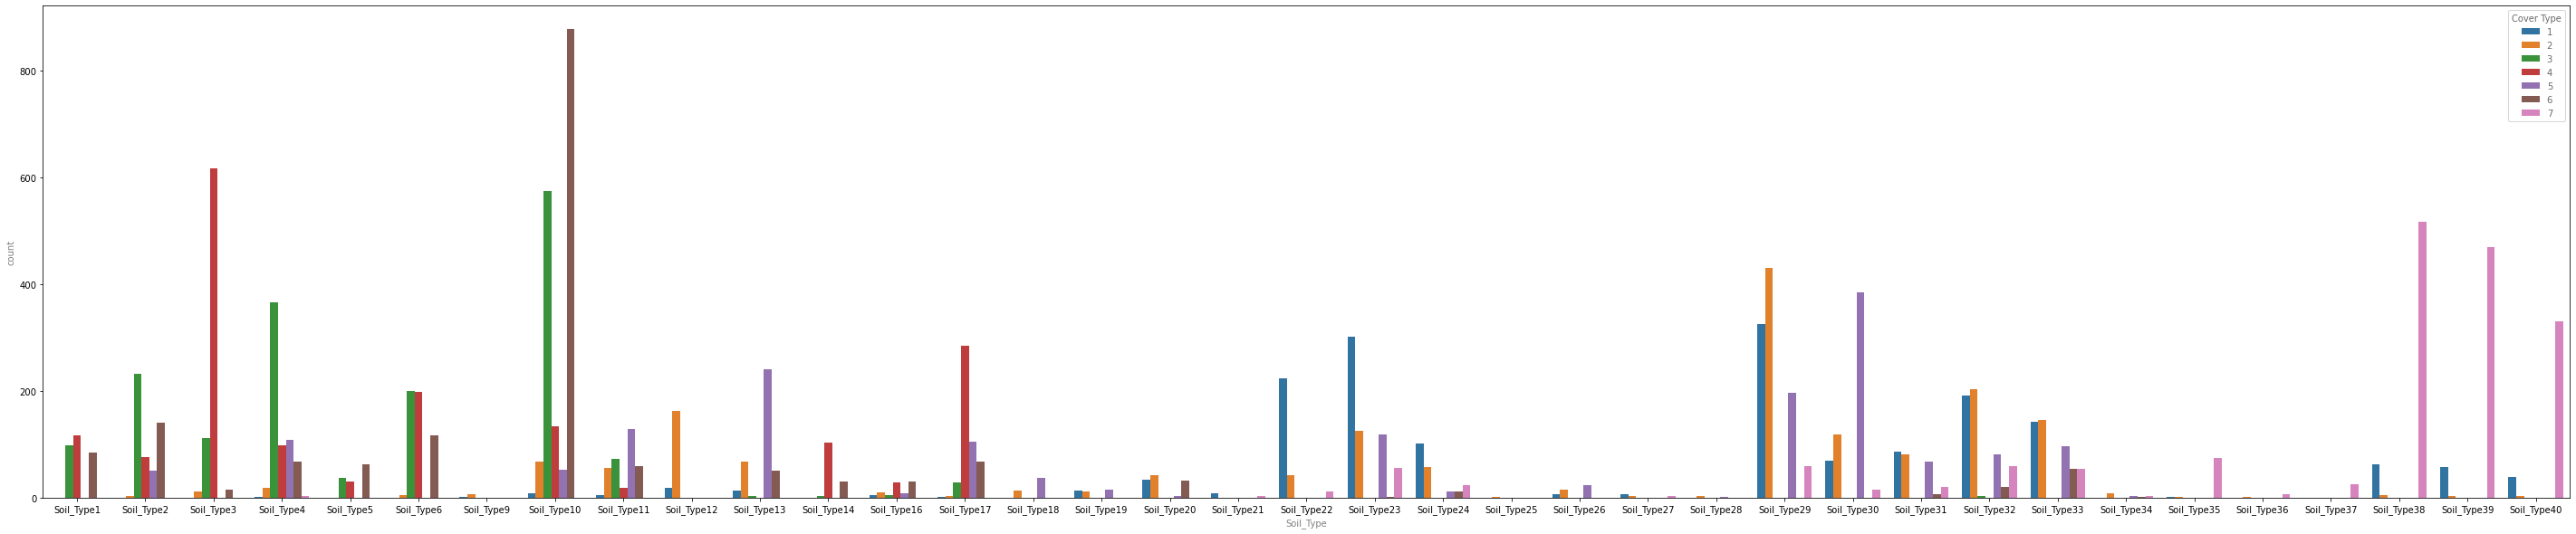

In [18]:
# Count plot - Soil Type
plt.figure(figsize=(50, 10))
ax = sns.countplot(x='Soil_Type', hue='Cover_Type', data=X_train_df_comb4)
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.0f}', (p.get_x(), p.get_height()+10))
plt.legend(loc='upper right', title='Cover Type')
plt.show()

**Observations**
- There are no cover types for Soil Type 7, 8 and 15.
- Cover type 7 outnumbers all other cover types for Soil Types 38, 39, and 40.
- Most data points for cover type 6 have Soil Type 10, but cover type 3 also has many data points with this Soil Type.

### Explore Wilderness Area Binary Counts

- As mentioned above, there aren't many data points in our training set that represent Wilderness Area 2.

In [19]:
train.groupby(['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'])['Cover_Type'].count()

Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4
0                 0                 0                 1                   3728
                                    1                 0                   5123
                  1                 0                 0                    382
1                 0                 0                 0                   2863
Name: Cover_Type, dtype: int64

### Determining if one Soil Type exists for each data point
- We checked that both the Soil Type and Wilderness Area variables are mutually exclusive within the columns (only one type and one area per row).

In [20]:
# Determining if one soil type exists for each data point
soil_type_cols = [col_name for col_name in train.columns if 'Soil_Type' in col_name]

X_train_df_soil = train.copy()
X_train_df_soil['Soil_Type_Count'] = X_train_df_soil[soil_type_cols].sum(axis = 1)
X_train_df_soil['Soil_Type_Count'].value_counts()

# Only one soil type exists for each row - no mix of different soil types

1    12096
Name: Soil_Type_Count, dtype: int64

## <a id = 8> </a>3. Data Transformation
[Back to Navigation](#0)

Here we set up our datasets for model building in Section 4.

- `Soil_Type7`, `Soil_Type8`, and `Soil_Type15` were dropped due to zero information
- Adding feature `Total_Distance_to_Hydrology` based on Euclidean distance
- Separate binary and continuous features for ease of fine-tuning in model building

In [21]:
# Drop any column that contains all zeros
zero_counts = pd.DataFrame({'zeros':train_data[train_data == 0].count(), 
                            'total':train_data.count()})
zero_features = zero_counts[zero_counts.zeros == zero_counts.total].index.to_list()

train_data_cp = train_data.copy()
dev_data_cp = dev_data.copy()
train_data_cp.drop(columns = zero_features, inplace = True)
dev_data_cp.drop(columns = zero_features, inplace = True)

In [22]:
# Create Total_Distance_to_Hydrology based on Euclidean distance
train_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(train_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                    + train_data_cp['Vertical_Distance_To_Hydrology']**2)
dev_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(dev_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                  + dev_data_cp['Vertical_Distance_To_Hydrology']**2)

In [23]:
# Separate binary and continuous features
continuous_features = list(train_data_cp.columns[0:10]) + ['Total_Distance_To_Hydrology']
binary_features = train_data_cp.columns[10:-1].to_list()

continuous_index = [train_data_cp.columns.tolist().index(f) for f in continuous_features]
binary_index = [train_data_cp.columns.tolist().index(f) for f in binary_features]

# Index and Column Name Checks
# print(train_data_cp.iloc[:,continuous_index].columns)
# print(train_data_cp.iloc[:,binary_index].columns)
# print(continuous_index)

### Use below datasets for model building, fine-tuning

In [24]:
X_train = train_data_cp[continuous_features + binary_features]
X_dev = dev_data_cp[continuous_features + binary_features]
y_train = train_labels.Cover_Type
y_dev = dev_labels.Cover_Type

## <a id = 9> </a>4. Initial Model Building/Selection

[Back to Navigation](#0)

## <a id = 10> </a> 4.1 Naive Bayes Model

[Back to Navigation](#0)
### Model Strategy and Results

Our first attempt for modeling this problem involved using the Naive Bayes classifier. Based on the course content and additional research that we had done, we believed that while Naive Bayes tends to be overconfident about results, the classifier tends to generalize well to different data sets.

We realized quickly, however, that our set of data includes both binary and continuous variables, which makes it more difficult to produce a Naive Bayes model. A Gaussian Naive Bayes model requires the use of continuous data, and a Bernoulli Naive Bayes model requires the data to be binary (or ordered, in the case of using a Multinomial model). There is not one model that utilizes both continuous and binary data.

There were several options we considered for improving the F1 Score and Accuracy of our Naive Bayes Model:

* Utilize only continuous features or only binary features
* Convert the continuous data into binary or multinomial data
* Combine the results of a Bernoulli model with the results of a Gaussian model
* Feature Transformation (Yeo-Johnson)
* Feature selection
* Model Smoothing

After extensive model tuning, we found that we could only reach a maximum F1 score of **62.9%** and an accuracy of **63.0%** using the Naive Bayes Classifier. While this in part could be due to having two classes of data, we believe that this data set also violates the independence assumption required for a Naive Bayes model, in which features are assumed to be independent. Based on our scatterplots above, it may be the case that our features are too closely related. 

A summary of our modeling iterations is presented in this section below, but a more detailed description of our results can be found in **Appendix B** at the end of this document.

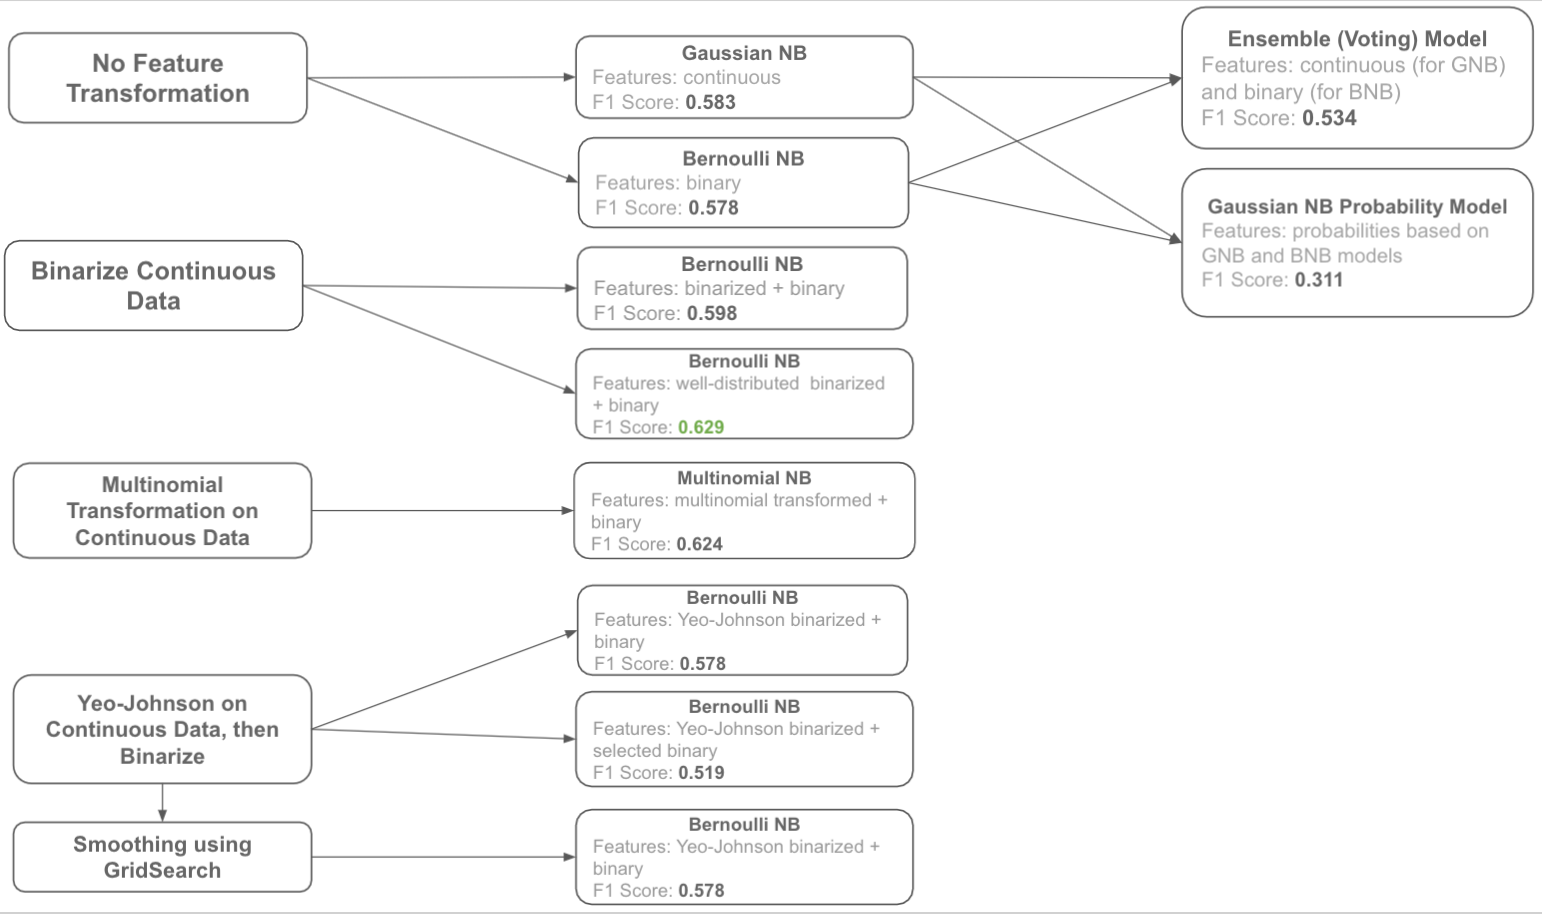

In [25]:
Image("../references/NB_Transformations.png")

## <a id = 11> </a>4.2 KNN Base Model

[Back to Navigation](#0)

### Model Strategy

Our second attempt was focused on employing a simpler model that would allow us to better identify and dissect parts of the problem. To accomplish this, we started with a simplistic k-Nearest Neighbors (KNN) model, which we could build on as we became more familiar with the inference problem. 


### Initial KNN Model
First, we will train and compare the following two KNN models:
- using the original features
- using normalized continuous features and the original binary features

In [26]:
# Transform continuous features to normalize

ct = ColumnTransformer([
        ('features', StandardScaler(), continuous_features)
        ], remainder='passthrough')

# Normalized Data
nX_train = ct.fit_transform(X_train)
nX_dev = ct.transform(X_dev)

# Describe data
# pd.DataFrame(nX_train, columns = X_train.columns).loc[:,continuous_features].describe()

In [27]:
# relabel outcome variable
y_train = train_labels.Cover_Type
y_dev = dev_labels.Cover_Type

# Ensure dimensions of transformed data matches original data
print("X_train Dimension:           ", X_train.shape)
print("Normalized X_train Dimension:", nX_train.shape)
print("X_dev Dimension:             ", X_dev.shape)
print("Normalized X_dev Dimension:  ", nX_dev.shape)

X_train Dimension:            (12096, 52)
Normalized X_train Dimension: (12096, 52)
X_dev Dimension:              (3024, 52)
Normalized X_dev Dimension:   (3024, 52)


After transforming the data and ensuring its integrity, we train and test the two basic models.

In [28]:
# Train and Test Standard and Normalized KNN Models
# Initial results
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred_y_dev = knn.predict(X_dev)
initial_accuracy = knn.score(X_dev, y_dev)
initial_f1_score = metrics.f1_score(y_dev, pred_y_dev, average = 'weighted')

# Print the results
print('Initial Accuracy: {:,.3f}'.format(initial_accuracy))
print('Initial F1 score: {:,.3f}'.format(initial_f1_score), '\n')

print('-- After Normalization --')
knn_norm = KNeighborsClassifier()
knn_norm.fit(nX_train, y_train)
pred_y_dev = knn_norm.predict(nX_dev)
accuracy = knn_norm.score(nX_dev, y_dev)
f1_score = metrics.f1_score(y_dev, pred_y_dev, average = 'weighted')

print('Accuracy: {:,.3f}'.format(accuracy))
print('F1 score: {:,.3f}'.format(f1_score), '\n')

Initial Accuracy: 0.806
Initial F1 score: 0.797 

-- After Normalization --
Accuracy: 0.786
F1 score: 0.781 



It seems like normalizing the data actually decreases our F1 and accuracy scores. Moving forward for the initial KNN model, we will use the original, non-normalized data. 

Next, we will attempt to search through a series of "k" values to find the best basic KNN model.

### Best Base KNN Model

In [29]:
# Use GridSearch to find optimal n of neighbors

# Turning this into a function so we can use it easily later
def best_knn(X, y):
    param_grid = dict(n_neighbors=range(1,30))
    grid = GridSearchCV(knn, param_grid, cv=10, n_jobs = -1, scoring = f1)
    grid.fit(X, y)
    # print(pd.DataFrame({'n_neighbors':grid.cv_results_['param_n_neighbors'], 'mean_f1_score':grid.cv_results_['mean_test_score']}))
    best_model = grid.best_estimator_
    return best_model
    
knn_norm_best = best_knn(X_train, y_train)
pred_y_dev = knn_norm_best.predict(X_dev)
f1_score = metrics.f1_score(y_dev, pred_y_dev, average = 'weighted')  
print('Best n-neighbors = {} | Best F1 score = {:.3f}'.format(knn_norm_best.n_neighbors, f1_score))

Best n-neighbors = 1 | Best F1 score = 0.842


After using `GridSearchCV` to find an optimal k-value for our KNN Model, we see our F1 score has risen to **84%**. 

Now, we will use this model to find which of our predictions are being confused most often. This will help us identify which subproblems we might want to isolate.  

### Base KNN Model - Confusion Matrix
First, we write a function to easily create confusion matrices.

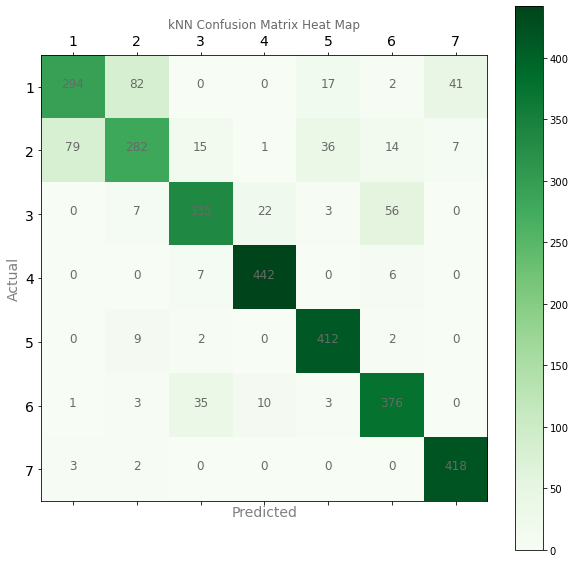

In [30]:
def calc_confusion_matrix (dev_labels, dev_pred):
    # Print confusion matrix in ASCII form
    conf_matrix = confusion_matrix(dev_labels, dev_pred) 
    
    # Produce confusion matrix in the form of heatmap
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111)
    cmx = ax.matshow(conf_matrix, cmap=plt.cm.Greens)
    plt.colorbar(cmx)
    
    plt.title('kNN Confusion Matrix Heat Map')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
    classNames = [str(i+1) for i in range(conf_matrix.shape[0])]    
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=0, fontsize=14)
    plt.yticks(tick_marks, classNames, fontsize=14)
   
    for i in range(len(classNames)):
        for j in range(len(classNames)):
            plt.text(j,i, str(conf_matrix[i][j]), size='large', horizontalalignment='center')    
    
    return conf_matrix

conf_matrix = calc_confusion_matrix(y_dev, pred_y_dev)

Next, we reformat the confusion matrix and replace the integer value in each cell with percent occurence. 

In [31]:
conf_matrix_df = pd.DataFrame(index = range(1,8), columns = range(1,8), data = conf_matrix)
conf_matrix_df.loc['total'] = conf_matrix_df.sum()
conf_matrix_df_sov = 100*conf_matrix_df.div(conf_matrix_df.loc['total']).iloc[:-1]
conf_matrix_df_sov.style.format('{:,.0f}%').background_gradient(cmap='Greens', axis = 0)

This confusion matrix supports our observations in the EDA section, showing that cover types 1 and 2 seem to be confused the most often, with cover types 3 and 6 getting confused the second most often.

### Base KNN Model - Summary

Reverting to a simpler model from Naive Bayes immediately produced better results and allowed us to do some quick hyperparameter tuning. From the confusion matrix above we have learned that the top 'confused' labels are 1 and 2, followed by 3 and 6. We will use this information to split our model into "sub-problems", as we attempt in the next section.

Additionlaly, while KNN as an initial model provided some benefits and simplicity, there are a number of downsides that led us to believe KNN will not be the best final solution:

First, KNN struggles with sparse data, which typically occurs with the use of binary features. For our binary variables, each point in our dataset will be associated with one of 40 Soil Types and one of 4 Wilderness areas. For each row, there will be a "1" for each column of these two inputs, and a "0" for the 42 other columns. This is an example of sparsity. When sparsity occurs, we run into the issue that the data points in the set are more different than they are alike, causing the closest 'neighbors' to be quite far away from one another. This increases the difficulty of our classification problem. 

Second, because KNN has no "fit" step, or rather no parameters, the final model would require storing all of the train data. This provides concerns for scalability, and processing time will increase dramatically if the test dataset is large at inference time.

## <a id = 12> </a> 5. Multi-Layer Modeling

[Back to Navigation](#0)

### Splitting the Problem into Layers
To reiterate, our base KNN model has two main groups which it confuses:
   1. 1 and 2
   2. 3 and 6

We will split our classification into three "layers", hoping to tune each layer to mitigate the incorrect predictions between the cover types listed above. Our layers are as follows:

- Layer 0: Classify cover type as 4, 5, 7, or "other" (1, 2, 3, 6)
- Layer 1: Classify cover type as 3, 6, or "other" (1, 2)
- Layer 2: Classify cover type as 1 or 2
     - At this point, we can no longer have "other", as this is the final classification step.

### Model Strategy 
We approach this multi-layer model from two directions:

 1. First, we run a basic multi-layer model, employing KNN at each step. This allows for an easy first implementation and a baseline to compare future improvements. 

 2. Second, we improve on each layer by tuning hyperparameters and choosing different models based on each subproblem. To do this, we have a custom algorithm that will search through both models and hyperparameters for quick comparisons and optimization. 

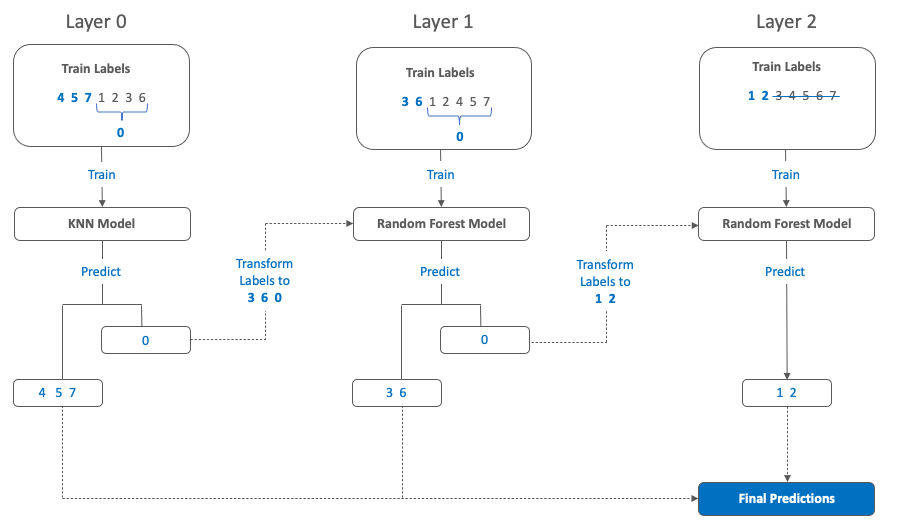

In [32]:
Image("../references/ThreeLayerSchema.png")

### Functions Used for our "Layered" Modeling

In [33]:
def relabel_y(y, other_labels):
    '''
    Purpose: For each subproblem, certain labels will be grouped into "other" category to focus model's attention on 
             labels of interest at given layer. This function will take a list of "other" labels, and group them all
             with label = 0. 
             
    Input:
      - y:           Labels for either train or dev data | Format: pandas df with index
      - other_label: List of labels in y which need to be grouped as "other" | Format: list or 1d iterable object
      
    Output:
      - y_new: Vector of original Label when label not in `other_labels`, otherwise '0' | Format: pandas df with index

    ''' 
        
    # Copy to save original df
    y_new = y.copy()
    
    for label in other_labels:
        
        # Relabel each label in 'other' as 0
        y_new[y_new == label] = 0
        
    return y_new # With original indices

In [34]:
def split_layer_data(test_data, test_labels, pred, other_label):
    '''
    Purpose: Aides in separating data that has been predicted to real label, vs. what has been predicted to "other" label.
             Data predicted as "other" must be passed to the next layer for additional classification
             
    Input:
      - test_data:   X input for model testing | Format: pandas df with index
      - test_labels: Expected y labels for model testing | Format: pandas df with index
      - pred:        Predicted y label from model | Format: numpy array (consistent with usual model.predict() output)
      - other_label: Label of the "other" group, which will need to be passed to the next layer for classification
      
    Output:
      - retry_data:       Data that will be passed to the next layer for further classification
      - retry_labels:     Labels that will be passed to the next layer for test of classification
      - keep_predictions: Predictions not of class "other" that will be retained as final predicted value
    '''
    
    # Assign prediction to correct index from original test data
    # Create a DataFrame with one column indicating the predicted value, and then 
    # set the indices to be those of the test_data set that correspond with the prediction
    predictions = pd.DataFrame({'pred': pred}).set_index(test_data.index)
    
    # Indices with "final" prediction values
    # Note: Some of the "final" prediction values could be wrong
    keep_index = np.array(predictions[predictions['pred'] != other_label].index).flatten()
    keep_predictions = predictions.loc[keep_index]
    
    # Indices to be ran through next layer
    retry_index = np.array(predictions[predictions['pred'] == other_label].index).flatten()
    retry_data = test_data.loc[retry_index]
    retry_labels = test_labels.loc[retry_index]
    
    return retry_data, retry_labels, keep_predictions

In [35]:
def calc_accuracy(y, y_hat): 
    '''
    Purpose: Simple accuracy calculation to allow for two vectors (pred, actual) to be passed
             for calculation without model, which is required in sklearn accuracy function
    '''
    
    y = np.array(y).flatten()
    y_hat = np.array(y_hat).flatten()
    correct = y == y_hat
    accur = np.sum(correct)/len(correct)
    
    return accur

## <a id = 13> </a> 5.1 Basic Three-Layer Model: KNN > KNN > KNN

[Back to Navigation](#0)

### Layer 0: Classify Cover Type as 4, 5, 7, or "other" (1, 2, 3, 6)

Layer 0 begins with predicting the cover types that yielded the best accuracies in our base KNN model. This first layer sets an upper bound for our prediction accuracy, so we would not want to start with tuning the worst-predicted cover types.

To begin, we will transform the train and dev labels to be either 4, 5, 7 or other (1, 2, 3, 6), which we denote as '0'. 

#### Transform the label data for Layer 0

In [36]:
# Transform the data to Focus on 4 v 5 v 7 v rest
exclude = [1, 2, 3, 6]

y_train_0 = relabel_y(y_train, exclude)
y_dev_0 = relabel_y(y_dev, exclude)

Next, we fit a (basic) model to classify 4, 5, 7, 0.

#### Generate and run the model

In [37]:
# Including all of the features for now
model_features = continuous_features + binary_features

knn_0_best = best_knn(X_train[model_features], y_train_0)                # Leverage best_knn to find best parameters
pred_y_dev = knn_0_best.predict(X_dev[model_features])                   # Predict
accuracy = knn_0_best.score(X_dev[model_features], y_dev_0)              # Accuracy
f1_score = metrics.f1_score(y_dev_0, pred_y_dev, average = 'weighted')   # F1

# Print the results
print('\nBest n-neighbors: ',knn_0_best.n_neighbors)
print('Layer 0 Accuracy: {:,.3f}'.format(accuracy))
print('Layer 0 F1 score: {:,.3f}'.format(f1_score), '\n')


Best n-neighbors:  1
Layer 0 Accuracy: 0.943
Layer 0 F1 score: 0.944 



This model has reasonably high accuracy to begin with, so it is a decent first layer. Here's where we go next:

* If our model predicts **4**, **5**, or **7**, we will **keep the prediction** (and its corresponding index) as our 'final' prediction for the data point.
* If our model predicts **0** ('other'), the data point will be **passed to the next layer**. 

This means the data needs to be split into the predictions we will keep and the predictions we will retry. Data and labels specific to Layer 1 will end in `_1`, and predictions from Layer 0 are saved in `pred_0`.

(NOTE: This model has not yet been improved upon, and any improvements are expected to increase overall accuracy of ensemble prediction.)

#### Transform the output from Layer 0 to be used for Layer 1

In [38]:
X_dev_1, y_dev_1, pred_0 = split_layer_data(test_data = X_dev, 
                                            test_labels = y_dev, 
                                            pred = pred_y_dev, 
                                            other_label = 0)

# Checks
# X_dev_1.shape[0] + pred_0.shape[0]    # Ensure all data retained (should sum to 3024)

# pred_0 contains the labels that were predictions we are keeping, in this case anything labeled 4, 5, or 7
# pred_0

### Layer 1: Classify Cover Type as 3, 6, or "other" (1, 2)

At this point, 4, 5, and 7 will no longer appear in "other", as they have been predicted out in Layer 0. 

Now we want to train a model that essentially ignores 4, 5, 7, and performs well predicting 3, 6 vs. the rest (1, 2).

Again, we will transform the train and dev labels to be either 3 or 6, or '0' (1, 2). Note that any incorrect predictions that were truly 4, 5, and 7 will also be grouped into other, but at this point there are very few examples of them since Layer 0 did well predicting them.

#### Transform the label data for Layer 1

In [39]:
# Transform the data
exclude = [1, 2, 4, 5, 7]

y_train_1 = relabel_y(y_train, exclude)
y_dev_1 = relabel_y(y_dev_1, exclude)
X_train_1 = X_train

#### Generate and run the model

In [40]:
# Including all of the features for now
model_features = continuous_features + binary_features

# Initial results
knn_1_best = best_knn(X_train_1[model_features], y_train_1)
pred_y_dev = knn_1_best.predict(X_dev_1[model_features])                         # Predict

accuracy = knn_1_best.score(X_dev_1[model_features], y_dev_1)                    # Accuracy
f1_score = metrics.f1_score(y_dev_1, pred_y_dev, average = 'weighted')           # F1

# Print the results
print('\nBest n-neighbors:',knn_1_best.n_neighbors)
print('Layer 1 Accuracy: {:,.2f}'.format(accuracy))
print('Layer 1 F1 score: {:,.2f}'.format(f1_score), '\n')


Best n-neighbors: 1
Layer 1 Accuracy: 0.91
Layer 1 F1 score: 0.91 



Again, this layer has fairly good accuracy in determining if an observation should be classified as 3, 6, or 0. The remainder of the data (anything classified as 0) will be passed to Layer 2 for final classification. The data passed to the next layer will be denoted with `_2`, and predictions from Layer 1 are saved in `pred_1`.

#### Transform the output from Layer 1 to be used for Layer 2

In [41]:
X_dev_2, y_dev_2, pred_1 = split_layer_data(test_data = X_dev_1, 
                                            test_labels = y_dev, 
                                            pred = pred_y_dev, 
                                            other_label = 0)

# pred_1.shape[0] + pred_0.shape[0] + X_dev_2.shape[0]    # Ensure all data retained
# pred_1 contains the labels that were predictions we are keeping from layer 1,
# in this case anything labeled 3 or 6
# pred_1['pred'].value_counts()

### Layer 2: Classify Remaining Cover Types as 1 or 2

**In the final layer, we can no longer predict "other" -- everything must be classified as 1 or 2.** While the overall accuracy of our multi-layer model does rely heavily on high scores in previous levels, we must also work on disambiguating 1 and 2 in this final layer to achieve good results. Otherwise, our overall accuracy may not deviate far from that of a single-layered model.

In this layer, the model will only be trained on examples labeled as 1 or 2, as we need our output to be one of these cover types. Because we are only training on observations with label 1 or 2, the `relabel_y` transformation is no longer necessary.

#### Transform the label data for Layer 2

In [42]:
# Subset data to only include examples with labels in [1, 2] for training
exclude = [3, 4, 5, 6, 7]

# Identify index
train_index_2 = y_train[~y_train.isin(exclude)].index

X_train_2 = X_train.loc[train_index_2]
y_train_2 = y_train.loc[train_index_2]

#### Generate and run the model

In [43]:
# Including all of the features for now
model_features = continuous_features + binary_features

# Initial results
knn_2_best = best_knn(X_train.loc[train_index_2, model_features], y_train_2)
pred_y_dev = knn_2_best.predict(X_dev_2[model_features])                       

# knn = KNeighborsClassifier().fit(X_train[model_features], y_train_2)    # Instantiate/Fit
# knn = KNeighborsClassifier().fit(X_train_2[model_features], y_train_2)    # Instantiate/Fit
# pred_y_dev = knn.predict(X_dev_2[model_features])                         # Predict
accuracy = knn_2_best.score(X_dev_2[model_features], y_dev_2)                    # Accuracy
f1_score = metrics.f1_score(y_dev_2, pred_y_dev, average = 'weighted')    # F1

# Print the results
print('\nBest n-neighbors:',knn_2_best.n_neighbors)
print('Layer 2 Accuracy: {:,.2f}'.format(accuracy))
print('Layer 2 F1 score: {:,.2f}'.format(f1_score), '\n')


Best n-neighbors: 1
Layer 2 Accuracy: 0.76
Layer 2 F1 score: 0.74 



This layer has fairly poor accuracy and will need to be further improved. Part of this may be due to the previous layers having passed non-1 or -2 observations to this layer, but there are likely a number of feature selection and hyper-parameter changes that should increase prediction accuracy. 

Additionally, as mentioned in the introduction, KNN will not do as well as some other models when data is very sparse. For Layer 2 training, we are subsetting the data to a small portion of our overall train data, which will cause each 'neighbor' to look further and further away. This means in our future improvements, we may want to try a different model for the final layer, or work on dimensionality reduction.

#### Transform Data from the final layer for final prediction

In [44]:
X_dev_3, y_dev_3, pred_2 = split_layer_data(test_data = X_dev_2, 
                                            test_labels = y_dev, 
                                            pred = pred_y_dev, 
                                            other_label = 0)

# pred_2.shape[0] + pred_0.shape[0] + pred_1.shape[0]

In [45]:
final_pred = pd.concat([pred_0, pred_1, pred_2], axis = 0).reindex(y_dev.index)
initial_3layer_f1 = metrics.f1_score(y_dev, final_pred, average = 'weighted')
initial_3layer_accuracy = calc_accuracy(y_dev, final_pred)

print('-- Original KNN --')
print(f'Initial Accuracy: {initial_accuracy:.2f}')
print(f'Initial F1 score: {initial_f1_score:.2f}\n')
print('-- Initial Three-Layer Model (KNN>KNN>KNN) --')
print(f'Accuracy: {initial_3layer_accuracy:.3f}')
print(f'F1 score: {initial_3layer_f1:.3f}\n')

-- Original KNN --
Initial Accuracy: 0.81
Initial F1 score: 0.80

-- Initial Three-Layer Model (KNN>KNN>KNN) --
Accuracy: 0.846
F1 score: 0.842



### Summary of Basic Three-Layer Model: KNN > KNN > KNN

This three-layer model provides an improvement to generalization from our most basic KNN, but fails to out-perform KNN with grid-searched hyperparameters. 

While this model does not give us the best prediction accuracy, it was useful in setting up the framework for a three-layer model, and will give us a baseline to improve upon. Layer 0 and 1 have reasonable F1 scores above 90%. Layer 2, however, causes our model to reduce prediction accuracy by quite a bit. Improving the final layer is one of our main focuses in the final model.

## <a id = 14> </a> 5.2 Final Three-Layer Model: KNN > RF > RF

[Back to Navigation](#0)

The flow of our final three-layer model will be similar to that of our base three-layer model. We split the larger problem into the same three sub-problems. At this stage however, **we will focus on the specific models and hyperparameters that are best suited for each layer/sub-problem.** Our final model resulted in using KNN as the first layer, Random Forest for the second layer, and another Random Forest for the final layer.

### Create Custom Modeling Class

To improve efficiency of model choosing, we will start by defining a class called `Model` that allows us to easily instantiate a number of different models. This class contains two methods, `featurePreprocessingScale` and `gridSearchCv`, which allow for us to quickly test different types of preprocessing and search across hyperparameters to determine optimal values given a dataset. 

#### `Model` Class

In [46]:
class Model():
    def __init__(self, model_type):
        self.model_type = model_type
        self.scaler_type = None
        self.X_train = None
        self.X_dev = None
        
        if model_type == 'kNN':
            self.model = KNeighborsClassifier()
        elif model_type == 'Gaussian_NB':
            self.model = GaussianNB()
        elif model_type == 'Bernoulli_NB':
            self.model = BernoulliNB()
        elif model_type == 'Multinomial_NB':
            self.model = MultinomialNB()
        elif model_type == 'Logistic_Regression':
            self.model = LogisticRegression(random_state=0, max_iter=10000)
        elif model_type == 'Decision_Tree':
            self.model = DecisionTreeClassifier(random_state=0, criterion='entropy')
        elif model_type == 'SVC':
            self.model = SVC(random_state=0, kernel='rbf')
        elif model_type == 'XGBoost':
            self.model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=0, n_jobs=-1)
        elif model_type == 'Neural_Net':
            self.model = MLPClassifier(random_state=0, max_iter=500)
        elif model_type == 'Random_Forest':
            self.model = RandomForestClassifier(random_state=0, n_jobs=-1)
        elif model_type == 'Extra_Tree':
            self.model = ExtraTreesClassifier(random_state=0, n_jobs=-1)
                  
    def featurePreprocessingScale(self, scaler_type, X_train, X_dev):
        self.scaler_type = scaler_type

        if scaler_type == 'MinMax':
            scaler = MinMaxScaler()
        elif scaler_type == 'Standard':
            scaler = StandardScaler()
        elif scaler_type == 'Robust':
            scaler = RobustScaler()
        
        continuous_features = list(X_train.columns[0:11]) + ['Total_Distance_To_Hydrology']
        scaled_features = ColumnTransformer(
            [('features', scaler, continuous_features)]
            ,remainder = 'passthrough'
        )
        
        X_train_scaled = scaled_features.fit_transform(X_train)
        X_dev_scaled = scaled_features.transform(X_dev)
        
        self.X_train_scaled = X_train_scaled
        self.X_dev_scaled = X_dev_scaled

        return([X_train_scaled, X_dev_scaled])
    
    def gridSearchCv(self, train_data, dev_data, train_labels, dev_labels,
                     params=None, scaler_type=None):
        
        self.X_train = train_data
        self.X_dev = dev_data        
        
        gscv = GridSearchCV(self.model, param_grid=params, cv=3, n_jobs=-1)
        
        if scaler_type != None:
            [self.X_train, self.X_dev] = self.featurePreprocessingScale(scaler_type, train_data, dev_data)

        gscv.fit(self.X_train, train_labels.values.ravel())
        dev_predict = gscv.predict(self.X_dev)
        
        self.best_model = gscv
        self.best_f1score = metrics.f1_score(dev_labels, dev_predict, average='weighted')
        self.best_accuracy = metrics.accuracy_score(dev_labels, dev_predict)
        self.dev_predict = dev_predict
        self.classification_report = classification_report(dev_predict, dev_labels)

#### `result` function

Next, we create a `result` function to aide in easy accuracy calculation and hyperparameter definition.

In [47]:
def result(Xtrain=train_data, Xdev=dev_data, ytrain=train_labels, ydev=dev_labels, printout=False):
    i = 1
    global finalResult_df
    finalResult_df = pd.DataFrame()
    for scalerType in scaler_options:
        for modelType in model_options:
            start_time = time.time()
            model = Model(model_type=modelType['model_type'])
            model.gridSearchCv(Xtrain, Xdev, ytrain, ydev,
                         params=modelType['params'], scaler_type=scalerType)
            end_time = time.time()
            if printout:
                print(
                f'''
                Model Number {i}: {modelType['model_type']}
                Scaler Type: {scalerType}
                Parameters: {modelType['params']}
                Best F1-Score: {model.best_f1score:.4f}
                Best Accuracy: {model.best_accuracy:.4f}
                Optimal Parameters: {model.best_model.best_params_}
                Run Time: {end_time-start_time:.2f}s
                '''
                )

            finalResult_df = finalResult_df.append(pd.DataFrame(
            {
                'Model Number':[i]
                ,'Model Type':[model.model_type]
                ,'Scaler Type':[scalerType]
                ,'F1-Score':[round(model.best_f1score, 4)]
                , 'Accuracy':[round(model.best_accuracy, 4)]
                ,'Optimal Parameters':[model.best_model.best_params_]
                ,'Run Time(s)':[round(end_time-start_time, 2)]
            }
            )
                                                  )
            i+=1

#### Defining Model Options

In our final model, we have reduced our list of searches to three models. However, earlier iterations included searches across many different models. 

In [48]:
scaler_options = [
    'MinMax',
    'Standard',
    'Robust',
    None
]


# For our final 
model_options = [
    {'model_type':'kNN','params':{'n_neighbors':list(range(1, 3))}},
#     {'model_type':'Gaussian_NB','params':{'var_smoothing':[0.001]}},
#     {'model_type':'Bernoulli_NB','params':{'alpha':[0.52943]}},
#     {'model_type':'Multinomial_NB','params':{'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}},
#     {'model_type':'Logistic_Regression','params':{'C':[500, 1000]}},
#     {'model_type':'Decision_Tree','params':{'max_leaf_nodes':[50]}},
#     {'model_type':'SVC','params':{'C':[10],'gamma':[0.5]}},  
#     {'model_type':'XGBoost','params':{'max_depth':[7],'subsample':[0.8],'n_estimators':[200]}},
#     {'model_type':'Neural_Net','params':{'hidden_layer_sizes':[(100,),(100,20)]}},
    {'model_type':'Random_Forest','params':{'n_estimators':[100, 200] }},
    {'model_type':'Extra_Tree','params':{'n_estimators':[100, 200],'criterion':['entropy','gini']}}
    
]

In [49]:
# result(Xtrain=X_train, Xdev=X_dev, ytrain=y_train, ydev=y_dev, printout=True)

In [50]:
# finalResult_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

### Layer 0: Classify Cover Type as 4, 5, 7, or "other" (1, 2, 3, 6)

Again, we will transform the train and dev labels to be either 4, 5, 7 or other (1, 2, 3, 6), which we denote as '0'. 

#### Transform the data for Layer 0

In [51]:
# Transform the data to Focus on 4 v 5 v 7 v rest
exclude = [1, 2, 3, 6]

y_train_0 = relabel_y(y_train, exclude)
y_dev_0 = relabel_y(y_dev, exclude)

#### Train KNN Model for Layer 0, searching for best hyperparameters and scaling type

In [52]:
ensemble_model_0_knn = Model(model_type='kNN')

scaler_type = None

params = {'n_neighbors':[1]}

start_time = time.time()
ensemble_model_0_knn.gridSearchCv(X_train, X_dev, y_train_0,
                                  y_dev_0, params, scaler_type)
# store layer 0 dev predict
dev_pred0 = ensemble_model_0_knn.dev_predict

end_time = time.time()

print(
f'''
Ensemble Model Layer 0 [Classify cover type as 4, 5, 7, or "other" (1, 2, 3, 6)]: {ensemble_model_0_knn.model_type}
Scaler Type: {scaler_type}
Parameters: {params}
Best F1-Score: {ensemble_model_0_knn.best_f1score:.4f}
Best Accuracy: {ensemble_model_0_knn.best_accuracy:.4f}
Optimal Parameters: {ensemble_model_0_knn.best_model.best_params_}
Run Time: {end_time-start_time:.2f}s
'''
)


Ensemble Model Layer 0 [Classify cover type as 4, 5, 7, or "other" (1, 2, 3, 6)]: kNN
Scaler Type: None
Parameters: {'n_neighbors': [1]}
Best F1-Score: 0.9437
Best Accuracy: 0.9435
Optimal Parameters: {'n_neighbors': 1}
Run Time: 0.86s



### Layer 1: Classify Cover Type as 3, 6, or "other" (1, 2)

#### Transform the output from Layer 0 to be used for Layer 1

In [53]:
X_dev_1, y_dev_1, pred_0 = split_layer_data(test_data = X_dev, 
                                            test_labels = y_dev, 
                                            pred = dev_pred0, 
                                            other_label = 0)

exclude = [1, 2, 4, 5, 7]

y_train_1 = relabel_y(y_train, exclude)
y_dev_1 = relabel_y(y_dev_1, exclude)

#### Use our `Model` class to search across models and hyperparameters to determine the optimal model

In [54]:
# Iterate through possible models using Model class above
result(X_train, X_dev_1, y_train_1, y_dev_1)
finalResult_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

Model Number     Model Type Scaler Type  F1-Score  Accuracy  \
0             12     Extra_Tree        None    0.9173    0.9175   
1              3     Extra_Tree      MinMax    0.9168    0.9169   
2              6     Extra_Tree    Standard    0.9168    0.9169   
3              9     Extra_Tree      Robust    0.9168    0.9169   
4             11  Random_Forest        None    0.9158    0.9163   
5              5  Random_Forest    Standard    0.9114    0.9119   
6              8  Random_Forest      Robust    0.9114    0.9119   
7              2  Random_Forest      MinMax    0.9095    0.9100   
8             10            kNN        None    0.9081    0.9069   
9              1            kNN      MinMax    0.8819    0.8834   
10             7            kNN      Robust    0.8737    0.8753   
11             4            kNN    Standard    0.8725    0.8741   

                               Optimal Parameters  Run Time(s)  
0      {'criterion': 'gini', 'n_estimators': 100}         8.49  
1   {'criterion': 'entropy', 'n_estimators': 200}        12.36  
2   {'criterion': 'entropy', 'n_estimators': 200}        11.87  
3   {'criterion': 'entropy', 'n_estimators': 200}        19.05  
4                           {'n_estimators': 200}         8.17  
5                           {'n_estimators': 200}         9.28  
6                           {'n_estimators': 200}         6.98  
7                           {'n_estimators': 200}         9.63  
8                              {'n_neighbors': 1}         1.92  
9                              {'n_neighbors': 1}         3.42  
10                             {'n_neighbors': 1}         3.44  
11                             {'n_neighbors': 1}         3.87

#### Choosing a Model for Layer 1

In the search we performed above, we can see that `Extra_Tree` with `Scaler Type = None` performed the best in terms of F1 score. While `Extra_Tree` provides marginally higher results (~0.15%), we chose to employ a `Random_Forest` model with 200 estimators for Layer 1. 

In our initial searches, we chose to include more complicated models that we came across outside of class, like `Extra_Tree`, `XGBoost`, and others for the sake of comparison. Because none of these outside models provide an extreme increase to F1, and their run time is longer on average, we choose to use the highest-performing model that was introduced in class. The student group has a deeper understanding of `Random_Forest` compared to `Extra_Tree`, and the reduction in run-time provides greater scalability given large datasets. 

#### Employing Random Forest for Layer 1

In [55]:
ensemble_model_1_rf = Model(model_type='Random_Forest')

scaler_type = None    # Based on Above Search

params = {'n_estimators':[200]}    # Based on Above Search

start_time = time.time()
ensemble_model_1_rf.gridSearchCv(X_train, X_dev_1, y_train_1,
                                  y_dev_1, params, scaler_type)
# store layer 1 dev predict
dev_pred1 = ensemble_model_1_rf.dev_predict

end_time = time.time()

print(
f'''
Ensemble Model Layer 1 [Classify cover type as 3, 6, or "other" (1, 2)]: {ensemble_model_1_rf.model_type}
Scaler Type: {scaler_type}
Parameters: {params}
Best F1-Score: {ensemble_model_1_rf.best_f1score:.4f}
Best Accuracy: {ensemble_model_1_rf.best_accuracy:.4f}
Optimal Parameters: {ensemble_model_1_rf.best_model.best_params_}
Run Time: {end_time-start_time:.2f}s
'''
)


Ensemble Model Layer 1 [Classify cover type as 3, 6, or "other" (1, 2)]: Random_Forest
Scaler Type: None
Parameters: {'n_estimators': [200]}
Best F1-Score: 0.9158
Best Accuracy: 0.9163
Optimal Parameters: {'n_estimators': 200}
Run Time: 4.93s



### Layer 2: Classify Remaining Cover Types as 1 or 2

Similar to Layer 1, we will again transform the data, as well as search through for the best model.

#### Transform the output from Layer 1 to be used for Layer 2

In [56]:
X_dev_2, y_dev_2, pred_1 = split_layer_data(test_data = X_dev_1, 
                                            test_labels = y_dev, 
                                            pred = dev_pred1,
                                            other_label = 0)

In [57]:
# Subset data to only include examples with labels in [1, 2] for training
exclude = [3, 4, 5, 6, 7]

# Identify index
train_index_2 = y_train[~y_train.isin(exclude)].index

X_train_2 = X_train.loc[train_index_2]
y_train_2 = y_train.loc[train_index_2]

In [58]:
# Iterate through models/parameters to determine ideal model
result(X_train_2, X_dev_2, y_train_2, y_dev_2)

# Output the Model Search Results table
finalResult_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

Model Number     Model Type Scaler Type  F1-Score  Accuracy  \
0              3     Extra_Tree      MinMax    0.7371    0.7645   
1              6     Extra_Tree    Standard    0.7371    0.7645   
2              9     Extra_Tree      Robust    0.7371    0.7645   
3             12     Extra_Tree        None    0.7349    0.7620   
4              5  Random_Forest    Standard    0.7309    0.7583   
5             11  Random_Forest        None    0.7297    0.7571   
6              2  Random_Forest      MinMax    0.7296    0.7571   
7              8  Random_Forest      Robust    0.7284    0.7559   
8             10            kNN        None    0.7015    0.7275   
9              1            kNN      MinMax    0.6957    0.7213   
10             4            kNN    Standard    0.6849    0.7102   
11             7            kNN      Robust    0.6802    0.7053   

                               Optimal Parameters  Run Time(s)  
0   {'criterion': 'entropy', 'n_estimators': 100}         4.49  
1   {'criterion': 'entropy', 'n_estimators': 100}         5.03  
2   {'criterion': 'entropy', 'n_estimators': 100}         6.27  
3      {'criterion': 'gini', 'n_estimators': 200}         5.27  
4                           {'n_estimators': 100}         2.98  
5                           {'n_estimators': 100}         4.39  
6                           {'n_estimators': 200}         3.14  
7                           {'n_estimators': 200}         5.08  
8                              {'n_neighbors': 1}         0.66  
9                              {'n_neighbors': 1}         0.68  
10                             {'n_neighbors': 1}         0.70  
11                             {'n_neighbors': 1}         1.26

#### Choosing a Model for Layer 2

Based on these results, we again choose a `Random_Forest` model over `Extra_Tree` for the same reasons discussed in Layer 1. We can see that in this layer, our search algorithm has provided different hyperparameters for `Random_Forest`. We will use a standard-scaled `Random_Forest` with 100 estimators for Layer 2, rather than the non-scaled 200-estimator `Random_Forest` that was determined as optimal for Layer 1.

### Experimenting with Dimensionality Reduction

Because Layer 2 has exhibited the lowest accuracy and F1 scores of all of all layers, we focus on tuning this particular layer in order to increase overall model accuracy. 

In addition to hyperparameter tuning and model selection, we experimented with different dimensionality reduction techniques in order to aide in generalization. Each of these techniques aide in reducing sparsity of data and lead to reductions in complexity. Principal Components Analysis (PCA) and Recursive Feature Elimination (RFE) shows some marginal increase to performance compared to the best Random Forest model. 

#### First, implementing Principal Component Analysis

In [59]:
start_time = time.time()

pca = PCA(n_components='mle', svd_solver='full')
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', pca)])

X_train_pca = pipeline.fit_transform(X_train_2)
et_X_train_pca_df = pd.DataFrame(data=X_train_pca
                              ,columns=[f'pca_comp{i}' for i in range(X_train_pca.shape[1])]
                              ,index=X_train_2.index)

X_dev_pca = pipeline.transform(X_dev_2)
et_X_dev_pca_df = pd.DataFrame(data=X_dev_pca
                            ,columns=[f'pca_comp{i}' for i in range(X_dev_pca.shape[1])]
                            ,index=X_dev_2.index)

model = RandomForestClassifier(
    random_state=0,
    n_estimators=100,
    n_jobs=-1
)

model.fit(et_X_train_pca_df, y_train_2.values.ravel())
dev_pred2_pca = model.predict(et_X_dev_pca_df) 
end_time = time.time()
et_f1_score = metrics.f1_score(y_dev_2, dev_pred2_pca, average = 'weighted')
et_accuracy = metrics.accuracy_score(y_dev_2, dev_pred2_pca)

print('--------- Implementing PCA --------')
print(f'''RF f1_score: {et_f1_score:.4f}
RF accuracy: {et_accuracy:.4f}
PCA components: {et_X_train_pca_df.shape[1]}
Run Time: {end_time-start_time:.2f}s\n''')

conf_matrix = confusion_matrix(y_dev_2, dev_pred2_pca)
print('Confusion Matrix:')
print(conf_matrix)

--------- Implementing PCA --------
RF f1_score: 0.7356
RF accuracy: 0.7633
PCA components: 46
Run Time: 1.12s

Confusion Matrix:
[[320  58   0   0   0   0   0]
 [ 77 299   0   0   0   0   0]
 [  0  16   0   0   0   0   0]
 [  0  12   0   0   0   0   0]
 [  0  10   0   0   0   0   0]
 [  0  14   0   0   0   0   0]
 [  5   0   0   0   0   0   0]]


#### Testing Recursive Feature Elimination

In [60]:
estimator = RandomForestClassifier(
    random_state=0,
    n_estimators=200,
    n_jobs=-1
)
selector = RFE(estimator, step=1)
selector = selector.fit(X_train_2, y_train_2)

# Including all of the features for now
model_features = continuous_features + binary_features

# This compares the model_features list with the True/False list and creates a list with the True features
final_features = list(compress(model_features, selector.support_))
print('--------- Implementing RFE --------')
print('Final Features: ', final_features)

--------- Implementing RFE --------
Final Features:  ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Total_Distance_To_Hydrology', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Soil_Type10', 'Soil_Type12', 'Soil_Type13', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39']


In [61]:
# Iterate through models/parameters to determine ideal model
result(X_train_2[final_features], X_dev_2[final_features], y_train_2, y_dev_2)

# Output the Model Search Results table
finalResult_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

Model Number     Model Type Scaler Type  F1-Score  Accuracy  \
0             11  Random_Forest        None    0.7382    0.7657   
1              2  Random_Forest      MinMax    0.7368    0.7645   
2              5  Random_Forest    Standard    0.7357    0.7633   
3              8  Random_Forest      Robust    0.7357    0.7633   
4             12     Extra_Tree        None    0.7255    0.7522   
5              3     Extra_Tree      MinMax    0.7254    0.7522   
6              6     Extra_Tree    Standard    0.7254    0.7522   
7              9     Extra_Tree      Robust    0.7254    0.7522   
8             10            kNN        None    0.7015    0.7275   
9              1            kNN      MinMax    0.6910    0.7164   
10             4            kNN    Standard    0.6896    0.7152   
11             7            kNN      Robust    0.6826    0.7078   

                            Optimal Parameters  Run Time(s)  
0                        {'n_estimators': 200}         3.44  
1                        {'n_estimators': 200}         4.68  
2                        {'n_estimators': 200}         5.74  
3                        {'n_estimators': 200}         3.86  
4   {'criterion': 'gini', 'n_estimators': 100}         4.32  
5   {'criterion': 'gini', 'n_estimators': 200}         5.80  
6   {'criterion': 'gini', 'n_estimators': 200}         6.24  
7   {'criterion': 'gini', 'n_estimators': 200}         5.48  
8                           {'n_neighbors': 1}         0.32  
9                           {'n_neighbors': 1}         0.60  
10                          {'n_neighbors': 1}         1.03  
11                          {'n_neighbors': 1}         0.50

While the improvements to generalization are small, we will move forward with RFE in effort to improve generalization at any level due to better scores. 

#### Train the Final Layer of the Model

In [62]:
ensemble_model_2_rf = Model(model_type='Random_Forest')

scaler_type = None

params = {'n_estimators':[200]}

start_time = time.time()
ensemble_model_2_rf.gridSearchCv(X_train_2[final_features], X_dev_2[final_features], y_train_2,
                                  y_dev_2, params, scaler_type)
# store layer 2 dev predict
dev_pred2_rfe = ensemble_model_2_rf.dev_predict

end_time = time.time()

print(
f'''
Ensemble Model Layer 2 [Classify cover type as 1 or 2]: {ensemble_model_2_rf.model_type}
Scaler Type: {scaler_type}
Parameters: {params}
Best F1-Score: {ensemble_model_2_rf.best_f1score:.4f}
Best Accuracy: {ensemble_model_2_rf.best_accuracy:.4f}
Optimal Parameters: {ensemble_model_2_rf.best_model.best_params_}
Run Time: {end_time-start_time:.2f}s
'''
)


Ensemble Model Layer 2 [Classify cover type as 1 or 2]: Random_Forest
Scaler Type: None
Parameters: {'n_estimators': [200]}
Best F1-Score: 0.7382
Best Accuracy: 0.7657
Optimal Parameters: {'n_estimators': 200}
Run Time: 3.68s



In [63]:
X_dev_3, y_dev_3, pred_2 = split_layer_data(test_data = X_dev_2, 
                                            test_labels = y_dev, 
                                            pred = dev_pred2_rfe, 
                                            other_label = 0)

In [64]:
final_pred = pd.concat([pred_0, pred_1, pred_2], axis = 0).reindex(y_dev.index)
final_f1 = metrics.f1_score(y_dev, final_pred, average = 'weighted')
final_accuracy = calc_accuracy(y_dev, final_pred)

print('\n---- Original Naive Bayes ----')
print('    Accuracy: 0.630')
print('    F1 score: 0.629\n')

print('--------- Original KNN --------')
print(f'    Accuracy: {initial_accuracy:.3f}')
print(f'    F1 score: {initial_f1_score:.3f}\n')

print('-- Initial Three-Layer Model --')
print('         (KNN>KNN>KNN)         \n')
print(f'    Accuracy: {initial_3layer_accuracy:.3f}')
print(f'    F1 score: {initial_3layer_f1:.3f}\n')

print('--- Final Three-Layer Model ---')
print('           (KNN>RF>RF)         \n')
print(f'    Accuracy: {final_accuracy:.3f}')
print(f'    F1 score: {final_f1:.3f}\n')


---- Original Naive Bayes ----
    Accuracy: 0.630
    F1 score: 0.629

--------- Original KNN --------
    Accuracy: 0.806
    F1 score: 0.797

-- Initial Three-Layer Model --
         (KNN>KNN>KNN)         

    Accuracy: 0.846
    F1 score: 0.842

--- Final Three-Layer Model ---
           (KNN>RF>RF)         

    Accuracy: 0.856
    F1 score: 0.853



## <a id = 15> </a> 6. Result Summary

[Back to Navigation](#0)

The diagram below conveys a summary of our modeling process.

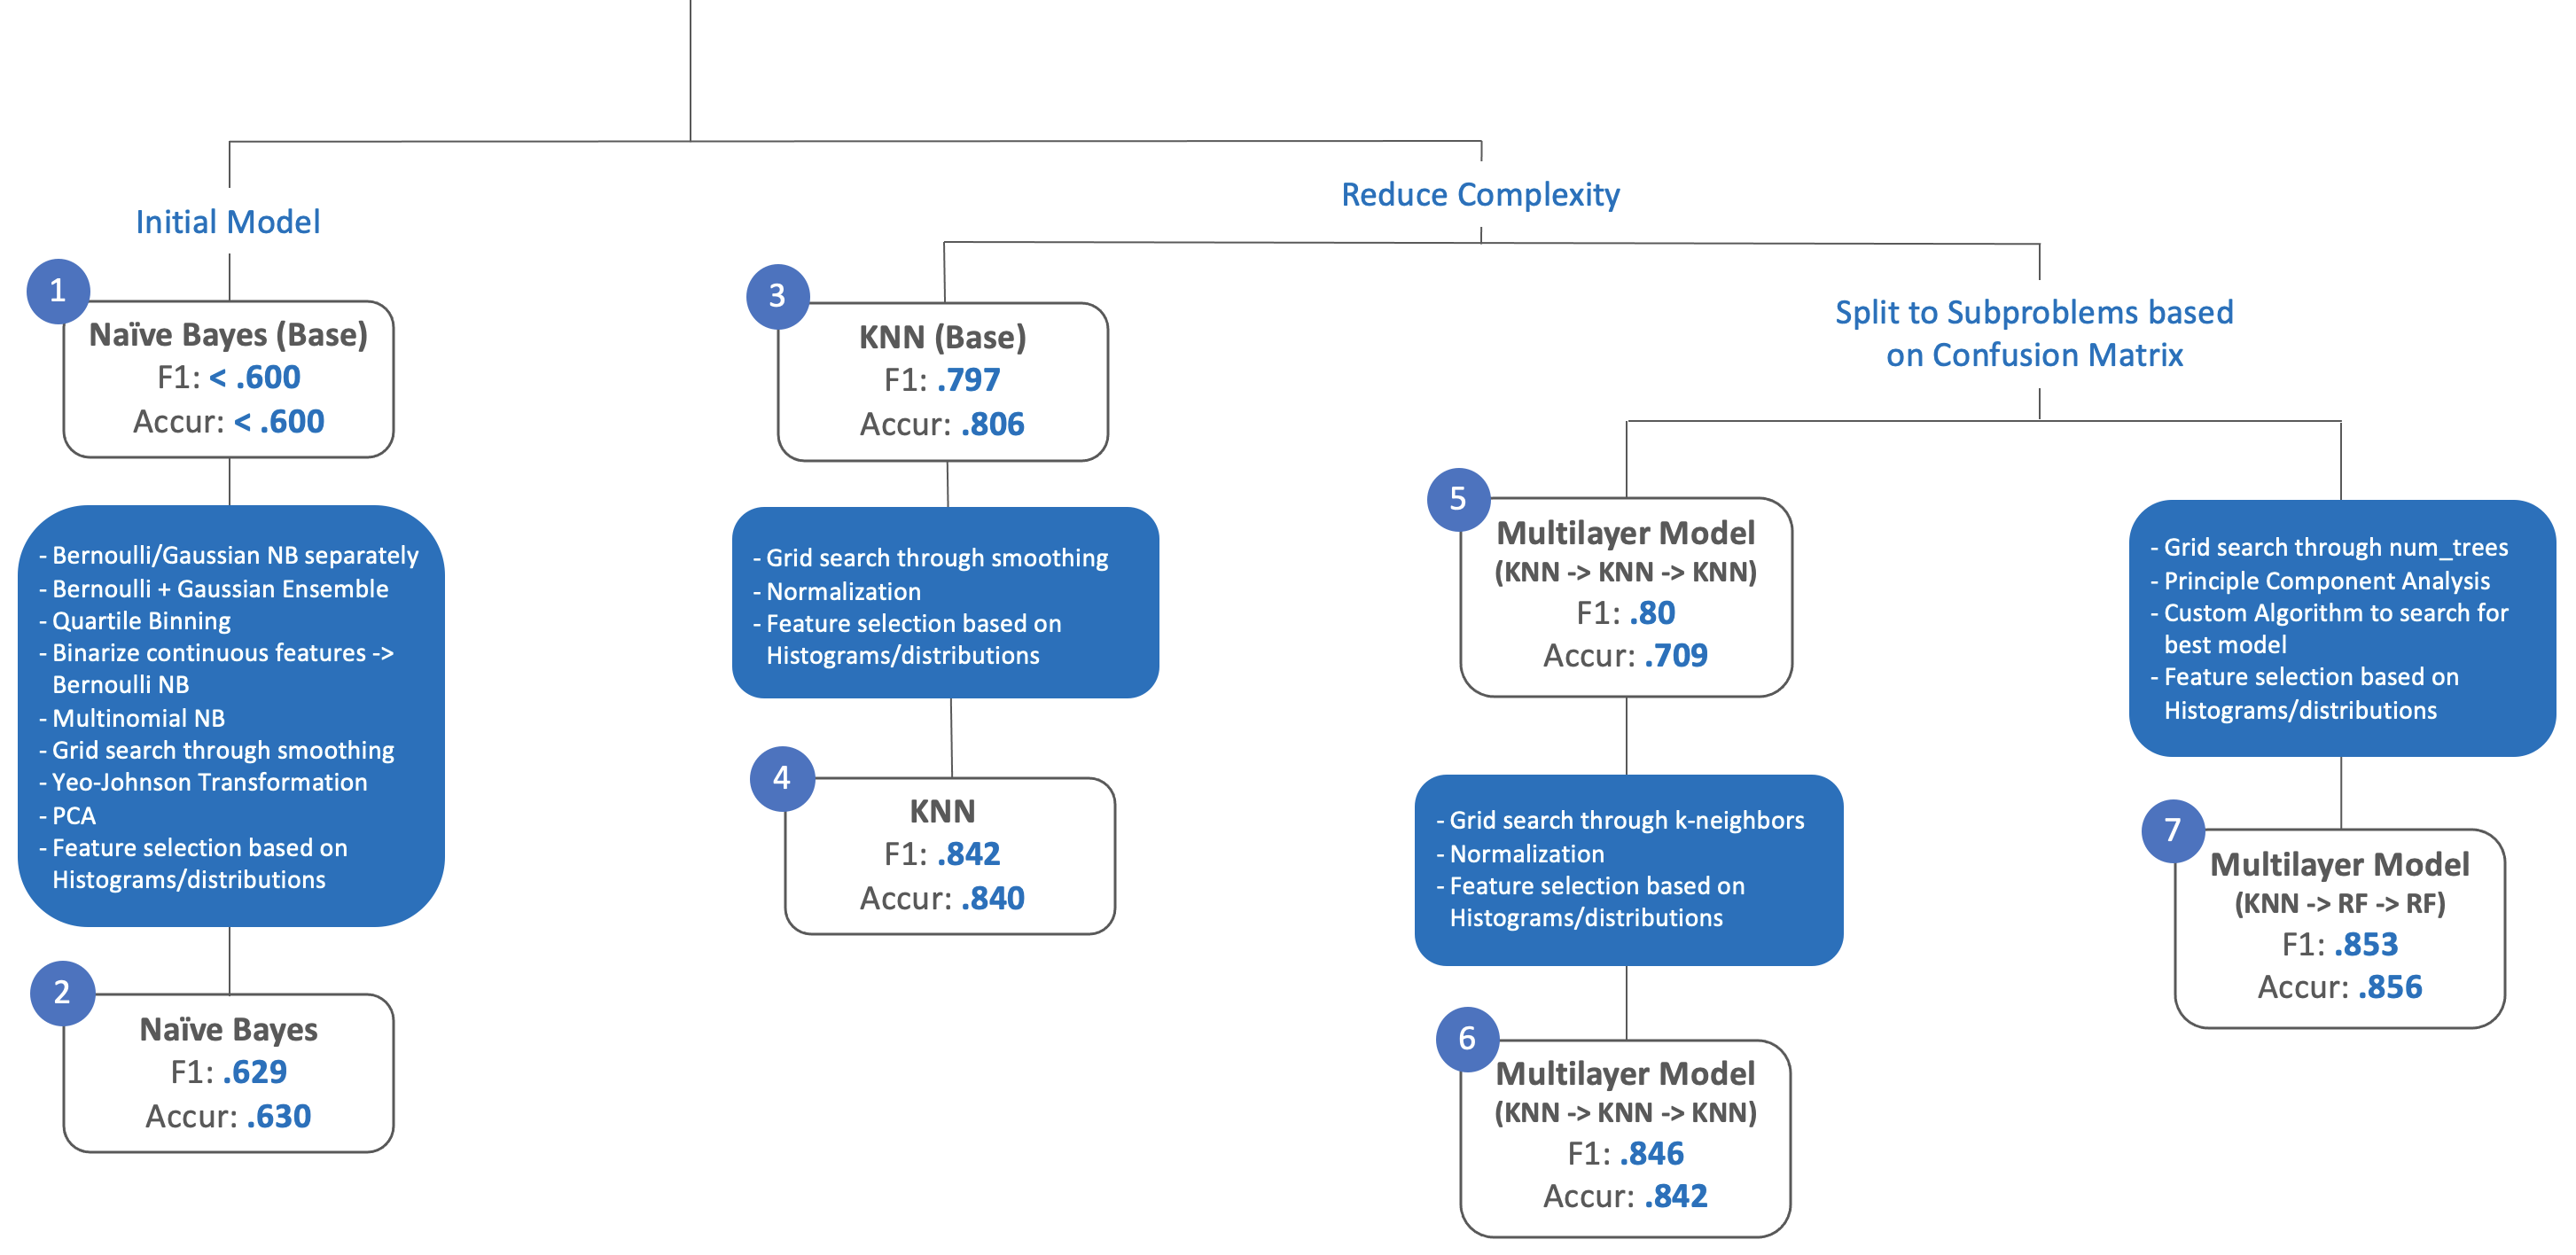

In [65]:
Image("../references/FinalResults.png")

We have trained and tested a number of models, with the purpose of improving our prediction ability at inference time. Below, we've summarized our process: 

 1. Beginning with Naive Bayes, we were able to predict with an accuracy and F1 just above 60%. This model proved more complicated and less effective than we imagined, which influenced us to try a simpler model, KNN. 

 2. Our most basic KNN model provided accuracy and F1 scores of roughly 80%, but its highest value was in allowing us to examine our data and outputs more simply. 

 3. Following our basic KNN, we determined that splitting our inference problem into subproblems would allow us to isolate our most confused cover types and tune these submodels at each layer. First-pass multilayer models yielded an F1 score and accuracy (~80%) that was below our optimized KNN scores, but provided an easy-to-understand framework to build upon. 

 4. Subsequent iterations of our multi-layer model surpassed all tested single-layer models, with a KNN>KNN>KNN three-layer model providing 84.6% accuracy and 84.2% F1 score, and our final KNN>RF>RF three-layer model providing **85.6%** accuracy and **85.3%** F1 score. 

At each stage, we focused on incremental improvements, choosing features based on underlying data and EDA, and varying parameters and hyperparameters to vary complexity and improve generalization. 

## <a id = 16> </a> 6.1 Future Improvements

[Back to Navigation](#0)

Due to the time constraints of our project, we were limited in our ability to explore many different parameter and hyper-parameter combinations. The second layer of our final three-layer model proves the greatest bottleneck to final prediction accuracy. 

Given additional time and resources, we would focus our attention on a more exhaustive search of hyperparameters. For example, SKLearn's `RandomForestClassifier` implementation offers many additional hyperparameters such as max_depth, min_samples_split, max_features, etc. that could be varied in hopes of improving prediction accuracy at inference time. 

Additionally, we believe that better feature engineering may also improve modeling accuracy. With limited knowledge of forestry and botany, our feature engineering was reduced to creating new features like `Total_Distance_To_Hydrology` and employing techniques such as RFE or PCA. With additional knowledge and time to research, we could have engineered new features that could better capture and summarize information complexity. 

Finally, our final models primarily included the majority of features before RFE. We believe further exploration into the data by class would allow us to select features with maximum amount of information. Our attempts at feature selection based on our EDA commononly provided miniscule, if not negative returns to generalization. 

## <a id = 17> </a> 7. Appendix

[Back to Navigation](#0)


## <a id = 18> </a> 7.1 Appendix A

[Back to Navigation](#0)

### EDA Extension

#### Boxplots for Continuous Features

- Cartographic features like Elevation, Aspect, and Slope 

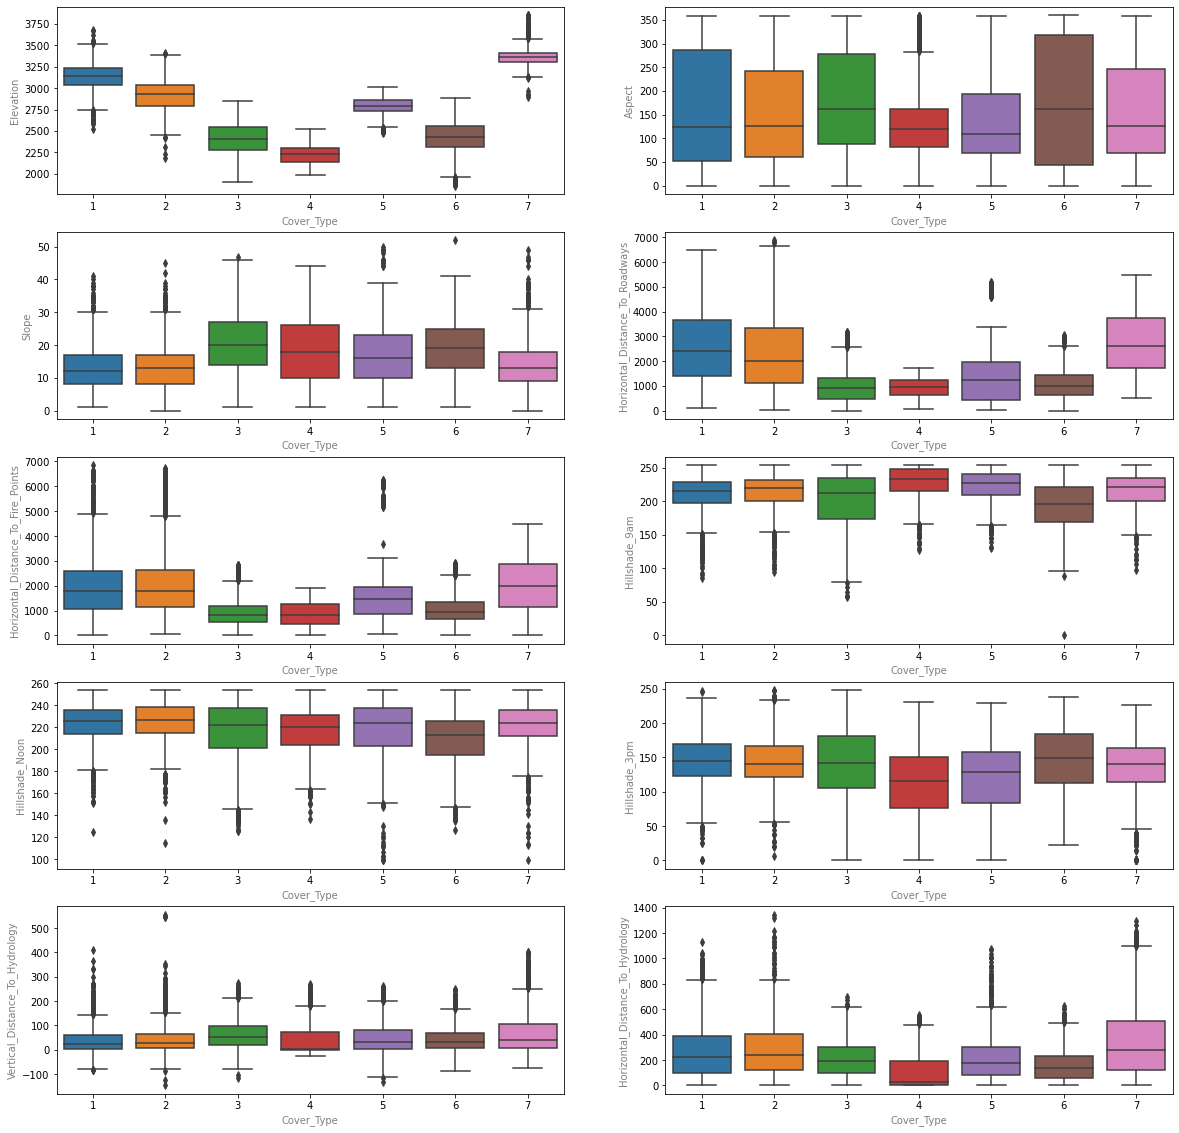

In [66]:
fig, ax = plt.subplots(5, 2, figsize = (20, 20))

feature_cols = ["Elevation", "Aspect", "Slope", 
                "Horizontal_Distance_To_Roadways", 
                "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                "Hillshade_Noon", "Hillshade_3pm", 
                "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology"] # Added these to feature_cols

for i, var in enumerate(feature_cols):
    row = i//2
    column = i%2
    sns.boxplot(x='Cover_Type', y=var, data=train, ax = ax[row][column])
    
plt.show()

## <a id = 19> </a> 7.2 Appendix B

[Back to Navigation](#0)

### Naive Bayes Models

As discussed in the introduction and EDA sections of the notebook, our features are represented by two different classes of data. We have **continuous variables** (elevation, aspect, slope, horizontal/vertical distance to hydrology, horizontal distance to roadways, hillshade, horizontal distance to fire points), and **binary variables** (wilderness areas, soil types), all of which are associated with 7 different tree cover types.

Because there is a mix of continuous/binary variables, we cannot just use a Gaussian (continuous) or Bernoulli (binary) Naive Bayes.

As a first pass, we train and evaluate models on the subsets of features that immediately fit into the models.

Later, feature selection, transformation, smoothing, and other methods will be performed for tuning our Naive Bayes models.

### Setup data sets for model tuning

In [67]:
# Re-initialize original dataframe used for modeling
zero_counts = pd.DataFrame({'zeros':train_data[train_data == 0].count(), 
                            'total':train_data.count()})
zero_features = zero_counts[zero_counts.zeros == zero_counts.total].index.to_list()

train_data_cp = train_data.copy()
dev_data_cp = dev_data.copy()
train_data_cp.drop(columns = zero_features, inplace = True)
dev_data_cp.drop(columns = zero_features, inplace = True)


# Total_Distance_to_Hydrology
# Create Total_Distance_to_Hydrology based on Euclidean distance
train_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(train_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                    + train_data_cp['Vertical_Distance_To_Hydrology']**2)
dev_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(dev_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                  + dev_data_cp['Vertical_Distance_To_Hydrology']**2)

# Separate the continuous and binary features
continuous_features = list(train_data_cp.columns[0:10]) + ['Total_Distance_To_Hydrology']
binary_features = train_data_cp.columns[10:-1].to_list()

continuous_index = [train_data_cp.columns.tolist().index(f) for f in continuous_features]
binary_index = [train_data_cp.columns.tolist().index(f) for f in binary_features]

# print(train_data_cp.iloc[:,continuous_index].columns)
# print(train_data_cp.iloc[:,binary_index].columns)

# For NB, we will remove 'Total_Distance_to_Hydrology', as this yielded better results
continuous_features.remove('Total_Distance_To_Hydrology') 

# Final Dataframes
X_train = train_data_cp[continuous_features + binary_features]
X_dev = dev_data_cp[continuous_features + binary_features]
y_train = train_labels.Cover_Type
y_dev = dev_labels.Cover_Type

#### Implement Gaussian Naive Bayes with strictly continuous features

In [68]:
# Fit Gaussian Naive Bayes
gausNB = GaussianNB().fit(X_train[continuous_features], np.array(y_train).ravel())          # Fit
gausNB_pred = gausNB.predict(X_dev[continuous_features])                  # Predict

gausNB_f1 = metrics.f1_score(y_dev, gausNB_pred, average = 'weighted')    # F1
gausNB_accur = gausNB.score(X_dev[continuous_features], y_dev)            # Accuracy

print('Gaussian Naive Bayes (Only continuous features)')
print(f'F1: {gausNB_f1:.3f} \nAccuracy: {gausNB_accur:.3f}')

Gaussian Naive Bayes (Only continuous features)
F1: 0.583 
Accuracy: 0.592


#### Implement Bernoulli Naive Bayes with strictly binary features

In [69]:
# Fit Bernoulli Naive Bayes
bNB = BernoulliNB().fit(X_train[binary_features], np.array(y_train).ravel())          # Fit
bNB_pred = bNB.predict(X_dev[binary_features])                      # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')    # F1
bNB_accur = bNB.score(X_dev[binary_features], y_dev)                # Accuracy

print('Bernoulli Naive Bayes (only binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (only binary features)
F1: 0.578 
Accuracy: 0.583


#### Ensemble Method: Voting with Gaussian NB and Bernoulli NB

Neither Bernoulli or Gaussian NB did particularly well on their own, so here we test an ensemble method - which attempts to leverage both in order to increase prediction accuracy. This should allow the continuous variables to be mostly predicted by the Gaussian NB, and binary variables to be mostly predicted by Bernoulli NB.

In [70]:
from sklearn.ensemble import VotingClassifier

clf1 = GaussianNB().fit(X_train[continuous_features], np.array(y_train).ravel())
clf2 = BernoulliNB().fit(X_train[binary_features], np.array(y_train).ravel())

eclf2 = VotingClassifier( estimators = [
                            ('GNB', clf1) , ('BNB', clf2)], voting = 'hard')
eclf2 = eclf2.fit(X_train, y_train)
preds = eclf2.predict(X_dev)
f1 = metrics.f1_score(y_dev, preds, average = 'weighted')
accur = eclf2.score(X_dev, y_dev)
print(f'Ensemble Naive Bayes (Bernoulli + Gaussian Voting)')
print(f'F1: {f1:.3f} \nAccuracy: {accur:.3f}')

Ensemble Naive Bayes (Bernoulli + Gaussian Voting)
F1: 0.534 
Accuracy: 0.577


This model performs worse than both of the isolated models above, with an F1 score of 0.534. We will try one more way of implmenting this below, a "by-hand" method of combining the original Gaussian and Bernoulli models.

#### Combine the results of a Bernoulli Model and a Gaussian Model

In [71]:
# Get probability predictions for each model
# On training data
G_train_probs = gausNB.predict_proba(X_train[continuous_features])
C_train_probs = bNB.predict_proba(X_train[binary_features])

# On dev data
G_dev_probs = gausNB.predict_proba(X_dev[continuous_features])
C_dev_probs = bNB.predict_proba(X_dev[binary_features])

# Combine probability prediction for class=1 from both models into a 2D array
# np.c_ translates slice objects to concatenation along the second axis.
X_new_train = np.c_[(G_train_probs[:,1], C_train_probs[:,1])] # Train
X_new_dev = np.c_[(G_dev_probs[:,1], C_dev_probs[:,1])] # Dev

# Fit final Gaussian model
# Using the probabilities from the last two modes as input
model = GaussianNB().fit(X_new_train, y_train)

# Predict class labels on dev data
pred_labels_dev = model.predict(X_new_dev)

combined_f1 = metrics.f1_score(y_dev, pred_labels_dev, average = 'weighted') 
combined_score = model.score(X_new_dev, y_dev)

print('Combined Gaussian and Bernoulli Probability Model')
print(f'F1: {combined_f1:.3f} \nAccuracy: {combined_score:.3f}')

Combined Gaussian and Bernoulli Probability Model
F1: 0.311 
Accuracy: 0.356


The combined model does extremely worse, with an F1 score of 0.311 and an accuracy of 0.356. This is unacceptable for a predictive model, so we will move away from this method. Next, we will attempt to binarize the continuous variables to input into a Bernoulli model.

#### Binarize Continuous Features

Even despite the combined model's unacceptable accuracy, we can still see that separately, the Gaussian model and the Bernoulli model do a poor job of prediction, each under 60% accuracy. Let's try to binarize some of the continuous variables across their means.

In [72]:
# Find mean of each continuous column and append to list
mean_list = []
for feature in continuous_features:
    mean_list.append(np.mean(X_train[feature]))

# Define function to binarize on the mean (referenced Week 2 Tutorial)
def binarize_data(data, feature_cols, thresholds = mean_list):
    '''
    Purpose: binarize continuous features, where 0 represents below (or equal to) mean, 1 represents above mean
    Input: continuous feature columns, names of features to be binarized, thresholds for binarization
    Output: binarized feature columns, same shape of input
    '''
    
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = data.copy() # avoid changing the original data

    # Apply a threshold  to each feature.
    i = 0
    for feature in feature_cols:
        binarized_data[feature] = 1 * (binarized_data[feature] > thresholds[i])
        i+=1
    return binarized_data

#### Test a Bernoulli NB model with Binarized + Binary Features

In [73]:
# Transform the continuous variables to binary
bin_train_X = binarize_data(X_train, continuous_features) # Binarize all continuous features
bin_dev_X = binarize_data(X_dev, continuous_features)

# Fit Bernoulli Naive Bayes
bNB2 = BernoulliNB().fit(bin_train_X, np.array(y_train).ravel())     # Fit
bNB_pred2 = bNB2.predict(bin_dev_X)                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred2, average = 'weighted')    # F1
bNB_accur = bNB2.score(bin_dev_X, y_dev)                             # Accuracy

print('Bernoulli Naive Bayes (all features binarized + binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (all features binarized + binary features)
F1: 0.598 
Accuracy: 0.605


Notice there are only marginal returns to accuracy after adding in binarized features. This could be for a number of reasons, but is most likely due to the distribution of each continuous variable. When we split on mean, we are making some assumption that this is a "good" split, which mostly relies on a bell-shaped distribution across the features with mean falling roughly in the middle.

What if we only binarize the features that are well distributed?

#### Test a Bernoulli NB model with only well-distributed features binarized

In [74]:
some_features = ['Elevation', 'Slope', 'Vertical_Distance_To_Hydrology', 'Hillshade_3pm']
model_features = some_features + binary_features
# model_features = some_features + binary_features[:13] + binary_features[14:]

# Transform the continuous variables to binary
bin_train_X = binarize_data(X_train, some_features) # Binarize a subset of continuous features
bin_dev_X = binarize_data(X_dev, some_features)

# Fit Bernoulli Naive Bayes
bNB2 = BernoulliNB().fit(bin_train_X, np.array(y_train).ravel())     # Fit
bNB_pred2 = bNB2.predict(bin_dev_X)                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred2, average = 'weighted')    # F1
bNB_accur = bNB2.score(bin_dev_X, y_dev)                             # Accuracy

print('Bernoulli Naive Bayes (some features binarized + binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (some features binarized + binary features)
F1: 0.629 
Accuracy: 0.630


#### Transform continuous features based on quantiles

Binarizing the continuous features may be too simple, resulting in too much information loss. Instead, we'll take the continuous features and transform them into multinomial data based on quantiles.

In [75]:
'''
Creating thresholds based on quantiles
'''
def define_thresholds(data, num_divisions):
    thresholds = np.zeros([len(data.columns), num_divisions-1])
    step = round(1/num_divisions,2)
    prev = 0
    bins = []
    for i in range(num_divisions-1):
        num = prev
        bins.append(num+step)
        prev = num+step
    print("Quantiles Chosen:", bins, '\n')
    
    i = 0
    for item in data.columns:
        for j in range(len(bins)):
            thresholds[i][j] = int(data[item].quantile(bins[j]))
        i+=1
    return thresholds

''' 
Convert Continuous Dataframe to Multifeature Dataframe

threshold:    NxM array, N = number of columns, M = number of bins
inputs:       dataframe, threshold values
outputs:      new dataframe
'''
def multifeature(data, thresholds):
    # capture column names
    features = list(data.columns)
    
    # initiate a new dataframe 
    new_df = data.copy()

    i=0
    # bin the data
    for feature in features:
        new_df[feature] = np.digitize(np.array(data[feature]), thresholds[i])
        i+=1
        
    return new_df

num_divisions = 4
thresholds = define_thresholds(X_train[continuous_features], num_divisions)
print("Thresholds for Train Data:\n", thresholds, '\n')
train_df = multifeature(X_train[continuous_features], thresholds)
dev_df = multifeature(X_dev[continuous_features], thresholds)

# This will merge our newly created multinomial features with the original binary features
Xtrain_multi = pd.merge(train_df, X_train[binary_features], left_on='Id', right_on='Id', how='left')
Xtrain_multi.shape

Xdev_multi = pd.merge(dev_df, X_dev[binary_features], left_on='Id', right_on='Id', how='left')
Xdev_multi.shape

Quantiles Chosen: [0.25, 0.5, 0.75] 

Thresholds for Train Data:
 [[2376. 2752. 3103.]
 [  65.  126.  261.]
 [  10.   15.   22.]
 [  67.  180.  330.]
 [   5.   32.   80.]
 [ 767. 1318. 2274.]
 [ 196.  220.  235.]
 [ 207.  223.  235.]
 [ 107.  138.  168.]
 [ 731. 1253. 1987.]] 



(3024, 51)

#### Test a Multinomial NB model with Multinomial Transformation + Binary Features

In [76]:
model = MultinomialNB(alpha=0.0001).fit(Xtrain_multi, y_train)
pred_y_dev = model.predict(Xdev_multi)
mNB_f1 = metrics.f1_score(y_dev, pred_y_dev, average = 'weighted')
mNB_accur = model.score(Xdev_multi, y_dev)
print('Bernoulli Naive Bayes (multinomial transformed features + binary features)')   
print(f'F1: {mNB_f1:.3f} \nAccuracy: {mNB_accur:.3f}')

# Confusion Matrix
cm = confusion_matrix(y_dev, pred_y_dev)
print('Confusion Matrix for Dev: \n\n', cm, "\n")

Bernoulli Naive Bayes (multinomial transformed features + binary features)
F1: 0.624 
Accuracy: 0.623
Confusion Matrix for Dev: 

 [[220 116   3   0  45   1  51]
 [ 93 234   8   0  82  15   2]
 [  0   2 201  50  39 131   0]
 [  0   0  44 387   0  24   0]
 [ 65  56  24   0 266  14   0]
 [  4  12 106  25  42 239   0]
 [ 42  33   0   0  10   0 338]] 



While this model produces high scores compared to most of our previous models, the prediction still isn't great. Next, we try testing other data transformations.

### Data Transformation
So far, the best model was a Bernoulli NB with "well-distributed" continuous variables binarized, and all binary features included.

Even then, prediction accuracy and F1 still hovered right around **63%**.

In an attempt to improve accuracy, we will next try to make the data better "fit" the model with transformations. First, we will bring some of our original EDA in to examine the distributions of continuous variables.

In [77]:
# Cell that defines function for plotting histograms
plt.rcParams.update({'text.color' : "dimgrey",
                     'axes.labelcolor' : "grey"})

def plot_histograms(features, data = X_train):
    
    fig, axes = plt.subplots(1, len(features))
    
    for i in np.arange(0, len(features)):          # For each non-binary figure in dataset

        data.iloc[:, i].plot.hist(ax = axes[i], 
                                    figsize = (50,10), 
                                    sharex = True, color = '#1c4966')

        

        axes[i].set_title("\n".join(wrap(features[i], 12)))
            
        # For All Plots
        axes[i].set_yticks([])
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_color('grey')
        axes[i].spines['bottom'].set_color('grey')
        axes[i].tick_params(colors = 'grey')

Based on the original histograms in the EDA section, some features appear to be a bit better distributed than others, but none of them are entirely normal. Therefore, we will consider transformations for each.

The Yeo-Johnson transformation is chosen as it is able to accept negative values, unlike other popular transformation algorithms like Box-Cox. Following transformation, each of the variables are also (0,1) normalized.

In [78]:
from sklearn.preprocessing import PowerTransformer

# Function to Transform variables using SKlearn PowerTransformer
def transform_vars(data, features, method = 'yeo-johnson', standardize = True, rename_cols = 'Y'):
    
    # Save indices
    indices = data.index
    
    # Fit the transformer
    pt = PowerTransformer(method = method, standardize = standardize)
    
    # Transform Data
    transformed_data = pd.DataFrame(pt.fit_transform(data[features])).set_index(indices)
    
    # Name columns
    if rename_cols == 'Y':
        transformed_data.columns = [f + '_transf' for f in features]
    else: 
        transformed_data.columns = features
        
    return transformed_data

In [79]:
# Transform the data
train_X_transf = transform_vars(data = X_train, features = continuous_features, 
               method = 'yeo-johnson', standardize = True, rename_cols = 'Y')
dev_X_transf = transform_vars(data = X_dev, features = continuous_features, 
               method = 'yeo-johnson', standardize = True, rename_cols = 'Y')

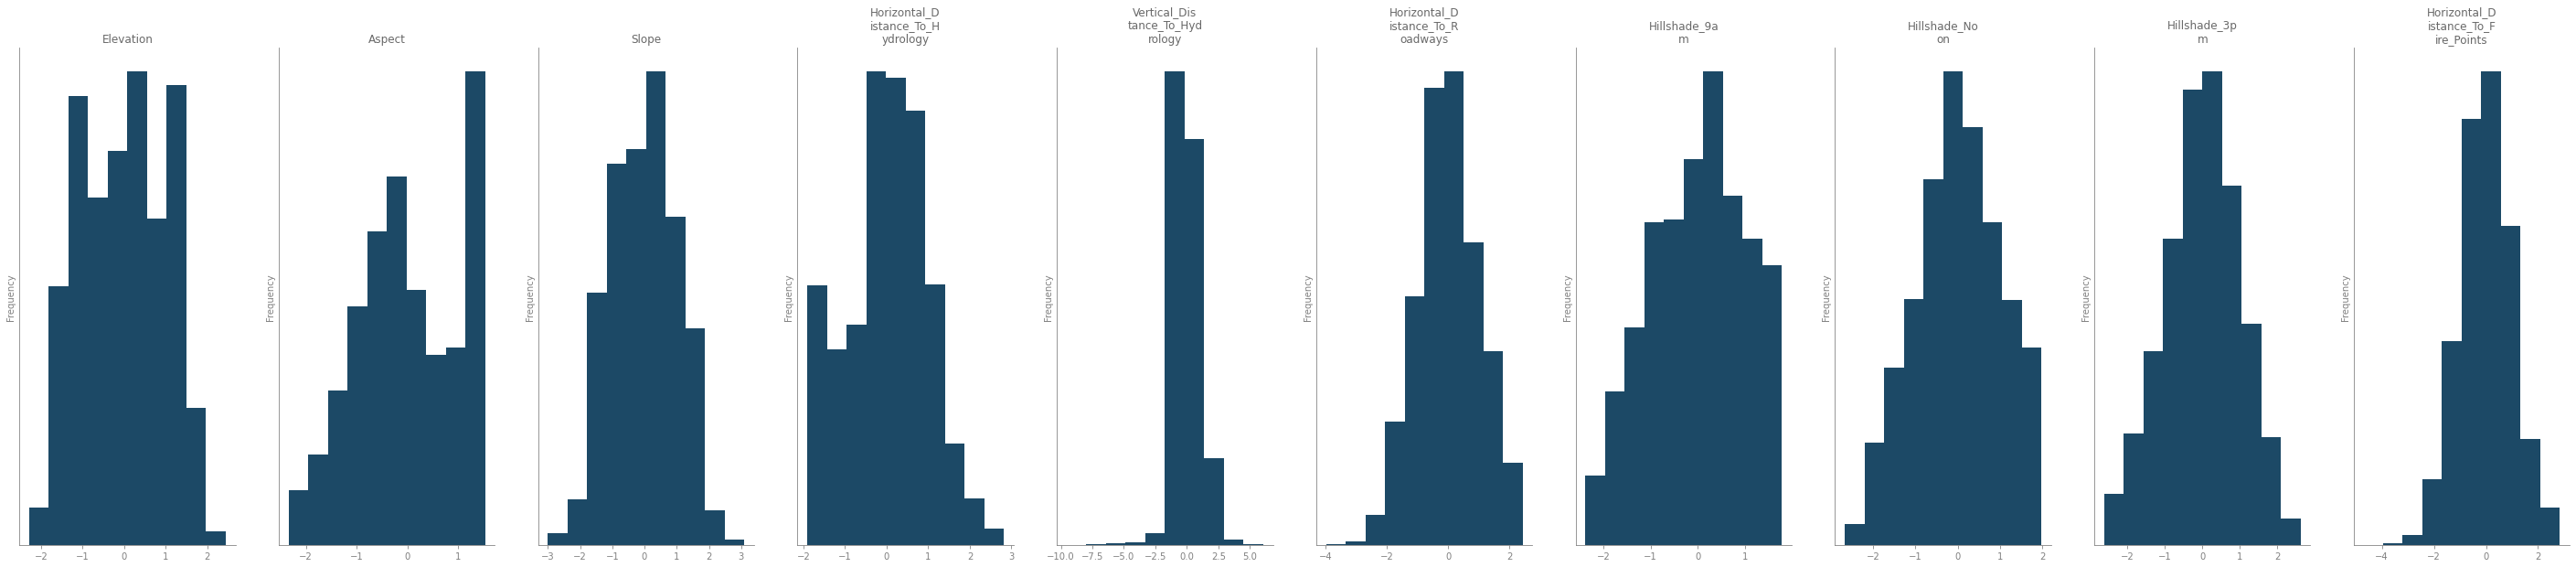

In [80]:
plot_histograms(continuous_features, train_X_transf)

Following transformation each continuous feature is certainly not pefectly normally distributed, but each of them look much more well-distributed, and it is believable that the mean would now fall roughly in the center.

#### Binarize each transformed variable

In [81]:
# Binarize the data
train_X_transf = binarize_data(train_X_transf, train_X_transf.columns) # Binarize all continuous features
dev_X_transf = binarize_data(dev_X_transf, train_X_transf.columns)

# Combine the new, transformed columns with original DF
train_X_full = X_train.merge(train_X_transf, how='left', on = X_train.index)\
                      .set_index(X_train.index)\
                      .drop(['key_0'], axis = 1)

dev_X_full = X_dev.merge(dev_X_transf, how='left', on = X_dev.index)\
                  .set_index(X_dev.index)\
                  .drop(['key_0'], axis = 1)

#### Bernoulli NB with Yeo-Johnson transformed/binarized continuous features, and binary features

Following transformation and binarization of the continuous features, now we can use Bernoulli Naive Bayes to model all of the features.

In [82]:
# Transformed/binarized features + binary features
model_features = list(train_X_transf.columns) + binary_features

# Fit Bernoulli Naive Bayes
bNB = BernoulliNB().fit(train_X_full[model_features], np.array(y_train).ravel())    # Fit
bNB_pred = bNB.predict(dev_X_full[model_features])                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')                    # F1
bNB_accur = bNB.score(dev_X_full[model_features], y_dev)                            # Accuracy

print('Bernoulli Naive Bayes (all features transformed/binarized + binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (all features transformed/binarized + binary features)
F1: 0.578 
Accuracy: 0.583


Following transformation and binarization, our model score has decreased compared to the "well-distributed" binarized model.

Next, we will try dropping a few columns that seem to be over-predicting Cover Type 6.

In [83]:
# Transformed/binarized features + binary features
model_features = list(train_X_transf.columns) + binary_features
model_features.remove('Soil_Type22')
model_features.remove('Soil_Type23')
model_features.remove('Soil_Type29')
model_features.remove('Soil_Type32')
model_features.remove('Soil_Type38')
model_features.remove('Soil_Type39')

# Fit Bernoulli Naive Bayes
bNB = BernoulliNB().fit(train_X_full[model_features], np.array(y_train).ravel())    # Fit
bNB_pred = bNB.predict(dev_X_full[model_features])                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')                   # F1
bNB_accur = bNB.score(dev_X_full[model_features], y_dev)                            # Accuracy

print('Bernoulli Naive Bayes (all features transformed/binarized + binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (all features transformed/binarized + binary features)
F1: 0.519 
Accuracy: 0.540


Since that decreased our F1 Score from 0.578 to 0.519, let's revert back to our model without the dropped soil types above and try searching for an "ideal" alpha value for smoothing. We will use the `GridSearchCV` function to do this.

In [84]:
from sklearn.model_selection import GridSearchCV

model_features = list(train_X_transf.columns) + binary_features

def GSCV(alphas):
    model = GridSearchCV(estimator = BernoulliNB(),
                         param_grid = alphas,
                         cv = 5,
                         scoring = 'accuracy',
                         iid = False)
    return model.fit(train_X_full[model_features], np.array(y_train).ravel())

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = GSCV(alphas)
print("Best alpha = ", nb.best_score_)

Best alpha =  0.5783728335252256


Next, plugging in the best alpha, test the model.

#### Use Grid Search to choose best parameters for original Yeo-Johnson model

In [85]:
# Transformed/binarized features + binary features
model_features = list(train_X_transf.columns) + binary_features

# Fit Bernoulli Naive Bayes
bNB = BernoulliNB(alpha = nb.best_score_).fit(train_X_full[model_features], np.array(y_train).ravel())    # Fit
bNB_pred = bNB.predict(dev_X_full[model_features])                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')                   # F1
bNB_accur = bNB.score(dev_X_full[model_features], y_dev)                            # Accuracy

print('Bernoulli Naive Bayes using GridSearch for smoothing (cont. features Yeo-Johnson transformed/binarized + binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes using GridSearch for smoothing (cont. features Yeo-Johnson transformed/binarized + binary features)
F1: 0.578 
Accuracy: 0.583


#### Initial search of best model using `Model` Class

After these attempts, we decided that we probably needed to try a new model. Here is our first attempt at using our `Model` class, which is introduced in Section 5.2.

In [86]:
# Adding Total_Distance_To_Hydrology since our Model Class requires it
# Create Total_Distance_to_Hydrology based on Euclidean distance
train_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(train_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                    + train_data_cp['Vertical_Distance_To_Hydrology']**2)
dev_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(dev_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                  + dev_data_cp['Vertical_Distance_To_Hydrology']**2)

# Separate the continuous and binary features
continuous_features = list(train_data_cp.columns[0:10]) + ['Total_Distance_To_Hydrology']
binary_features = train_data_cp.columns[10:-1].to_list()

continuous_index = [train_data_cp.columns.tolist().index(f) for f in continuous_features]
binary_index = [train_data_cp.columns.tolist().index(f) for f in binary_features]

# Final Dataframes
X_train = train_data_cp[continuous_features + binary_features]
X_dev = dev_data_cp[continuous_features + binary_features]
y_train = train_labels.Cover_Type
y_dev = dev_labels.Cover_Type

In [87]:
result(Xtrain=X_train, Xdev=X_dev, ytrain=y_train, ydev=y_dev, printout=True)


                Model Number 1: kNN
                Scaler Type: MinMax
                Parameters: {'n_neighbors': [1, 2]}
                Best F1-Score: 0.8138
                Best Accuracy: 0.8168
                Optimal Parameters: {'n_neighbors': 1}
                Run Time: 5.03s
                

                Model Number 2: Random_Forest
                Scaler Type: MinMax
                Parameters: {'n_estimators': [100, 200]}
                Best F1-Score: 0.8640
                Best Accuracy: 0.8664
                Optimal Parameters: {'n_estimators': 200}
                Run Time: 11.55s
                

                Model Number 3: Extra_Tree
                Scaler Type: MinMax
                Parameters: {'n_estimators': [100, 200], 'criterion': ['entropy', 'gini']}
                Best F1-Score: 0.8638
                Best Accuracy: 0.8657
                Optimal Parameters: {'criterion': 'gini', 'n_estimators': 200}
                Run Time: 18.05s
            

In [88]:
finalResult_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

Model Number     Model Type Scaler Type  F1-Score  Accuracy  \
0             11  Random_Forest        None    0.8689    0.8707   
1             12     Extra_Tree        None    0.8683    0.8700   
2              8  Random_Forest      Robust    0.8651    0.8674   
3              5  Random_Forest    Standard    0.8644    0.8667   
4              2  Random_Forest      MinMax    0.8640    0.8664   
5              3     Extra_Tree      MinMax    0.8638    0.8657   
6              6     Extra_Tree    Standard    0.8638    0.8657   
7              9     Extra_Tree      Robust    0.8638    0.8657   
8             10            kNN        None    0.8420    0.8462   
9              1            kNN      MinMax    0.8138    0.8168   
10             7            kNN      Robust    0.7956    0.7993   
11             4            kNN    Standard    0.7918    0.7960   

                               Optimal Parameters  Run Time(s)  
0                           {'n_estimators': 200}        14.39  
1   {'criterion': 'entropy', 'n_estimators': 200}        20.92  
2                           {'n_estimators': 200}        10.24  
3                           {'n_estimators': 200}        13.20  
4                           {'n_estimators': 200}        11.55  
5      {'criterion': 'gini', 'n_estimators': 200}        18.05  
6      {'criterion': 'gini', 'n_estimators': 200}        17.09  
7      {'criterion': 'gini', 'n_estimators': 200}        19.16  
8                              {'n_neighbors': 1}         2.30  
9                              {'n_neighbors': 1}         5.03  
10                             {'n_neighbors': 1}         5.08  
11                             {'n_neighbors': 1}         2.99

## <a id = 20> </a> 7.3 Appendix C

[Back to Navigation](#0)
### Final Model Prediction Output

Since we have not wrapped our three-layer model into a single function or class, we do this below.

In [89]:
def split_layer_data_test(test_data, pred, other_label):
    '''
    Purpose: Aides in separating data that has been predicted to real label, vs. what has been predicted to "other" label.
             Data predicted as "other" must be passed to the next layer for additional classification
             
    Input:
      - test_data:   X input for model testing | Format: pandas df with index
      - test_labels: Expected y labels for model testing | Format: pandas df with index
      - pred:        Predicted y label from model | Format: numpy array (consistent with usual model.predict() output)
      - other_label: Label of the "other" group, which will need to be passed to the next layer for classification
      
    Output:
      - retry_data:       Data that will be passed to the next layer for further classification
      - retry_labels:     Labels that will be passed to the next layer for test of classification
      - keep_predictions: Predictions not of class "other" that will be retained as final predicted value
    '''
    
    # Assign prediction to correct index from original test data
    # Create a DataFrame with one column indicating the predicted value, and then 
    # set the indices to be those of the test_data set that correspond with the prediction
    predictions = pd.DataFrame({'pred': pred}).set_index(test_data.index)
    
    # Indices with "final" prediction values
    # Note: Some of the "final" prediction values could be wrong
    keep_index = np.array(predictions[predictions['pred'] != other_label].index).flatten()
    keep_predictions = predictions.loc[keep_index]
    
    # Indices to be ran through next layer
    retry_index = np.array(predictions[predictions['pred'] == other_label].index).flatten()
    retry_data = test_data.loc[retry_index]
    
    return retry_data, keep_predictions

In [90]:
test_data = pd.read_csv('../data/processed/test.csv').set_index('Id')

#### Transform test data as above

In [91]:
test_data_cp = test_data.copy()
test_data_cp.drop(columns = zero_features, inplace = True)

test_data_cp['Total_Distance_To_Hydrology'] = np.sqrt(test_data_cp["Horizontal_Distance_To_Hydrology"]**2 
                                                    + test_data_cp['Vertical_Distance_To_Hydrology']**2)

X_test = test_data_cp[continuous_features + binary_features]

### Layer 0

In [92]:
# Transform the data to Focus on 4 v 5 v 7 v rest
exclude = [1, 2, 3, 6]

y_train_0 = relabel_y(y_train, exclude)
# y_dev_0 = relabel_y(y_dev, exclude)

# Train
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_train, y_train_0)

# Predict
pred_y_test = knn.predict(X_test)

#### Transform output from Layer 0 for Layer 1

In [93]:
X_test_1, pred_0 = split_layer_data_test(test_data = X_test, 
                                            # Modified from original `split_layer_data` function
                                            pred = pred_y_test, 
                                            other_label = 0)

### Layer 1

In [94]:
# Transform the data to focus on 3, 6 vs. rest
exclude = [1, 2, 4, 5, 7]

y_train_1 = relabel_y(y_train, exclude)

model = RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 200).fit(X_train, y_train_1)
pred_y_dev = model.predict(X_test_1)

#### Transform Output from Layer 1 for Layer 2

In [95]:
# Split the data for Layer 2
X_test_2, pred_1 = split_layer_data_test(test_data = X_test_1, 
                                         pred = pred_y_dev,
                                         other_label = 0)

### Layer 2

#### Being the Final Layer, data must be further transformed to include only observations labeled 1 or 2 for train

In [96]:
# Exclude all "other" labels for final layer
exclude = [3, 4, 5, 6, 7]

# Data for training final layer
train_index_2 = y_train[~y_train.isin(exclude)].index

X_train_2 = X_train.loc[train_index_2]
y_train_2 = y_train.loc[train_index_2]

In [97]:
model = RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 200).fit(X_train_2, y_train_2)
pred_y_test = model.predict(X_test_2)

In [98]:
X_test_3, pred_2 = split_layer_data_test(test_data = X_test_2, 
                                         pred = pred_y_test,
                                         other_label = 0)

In [99]:
final_test_pred = pd.concat([pred_0, pred_1, pred_2], axis = 0).reindex(X_test.index)

#### Rename for kaggle

In [100]:
final_test_pred.rename(columns = {'pred': 'Cover_Type'}, inplace= True)

In [101]:
# final_test_pred.to_csv('../data/processed/test_predictions.csv')

#### Kaggle Submission Result

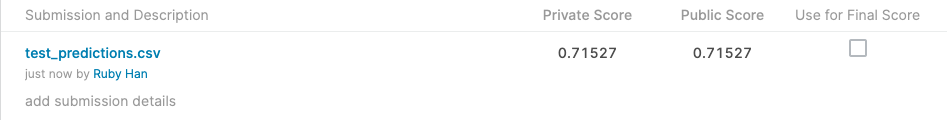

In [102]:
Image("../data/processed/kaggle_result.png")